# Final Project: Impact of the Corona Virus on the Loan Industry

By Carter Pace, Spencer Siegel, Austin Cobb, Sarah Parker, Cecilia Zeng, Varun Srivstava

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve

## Introduction

For our final project, the team decided to tackle assignment 3 one more time, specifically for redemption of our inability to accurately predict returns on investment. To recap the original goals of the assignment, our team was tasked with assisting Dr. D in his investment strategies. Dr. D has decided to use our team to invest $10,000,000 into the peer2peer lending platform, Lending Club. Given historical Lending Club data, dating between 2009 & 2018, our goal for this assignment is to effectively predict default and return to build an investment strategy that both maximizes return and minimizes risk of default. However, our team also looked into benchmarks to compare our models to in case there are better alternatives for Dr. D to invest his money in, such as ETFs, indices, bundled bonds & stocks, etc. 

The data set from Lending Club consists of over 151 variables and 30 million records, so developing an investment strategy that can be backed by data posed quite the task. Our team recognized that having this many variables can actually be a curse because many of them deceivingly do not have any weight on the decision of whether or not a loan will default. Before training and testing any models, our team needed to clean the data by handling missing data and outliers, eliminating variables via feature importance, etc. 

In addition, our team also decided to analyze the impact of the coronavirus on the loan industry. The current COVID-19 crisis has resulted in the worldwide shutdowns of economies, including the United States. People are losing jobs, industries are shutting down, and there is widespread concern of being able to afford basic necessities. Because of this current environment, the loan industry has taken a hit, especially peer2peer lending. Investors are becoming skittish and borrowers are at a higher risk for default. Without the actual Lending Club data for 2019 & 2020, our team is utilizing competitive research and sentiment analysis to determine Dr. D's best course of action if he were to invest his money in the economy's current state, whether this means holding his money, utilizing Lending Club, or moving to antoher source.

Just like in the original assignment, the first step in this process is gathering, cleaning, and manipulating the data to prepare for modeling and analysis. Much of this code has stayed the same because our team had an effective and well thoughtout strategy of how to eliminate variables in the dataset to ease analysis. 

## Gathering Data

The first step to running the prediction models and cleaning the Lending Club dataset to get a much more manageable set of variables. 

In [2]:
df_accepted = pd.read_csv("accepted_2007_to_2018Q4.csv")

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(df_accepted.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB
None


Currently, in the *accepted loan* dataset, there are approximately 2.2 million entries with 151 variables. 

In [4]:
df_accepted.shape

(2260701, 151)

The task for this project is to assist Dr. D in developing a smart investment strategy by using historical data to to build a model that predicts the outcome of loans (fully paid, default, etc.) and building a model to predicts expected return. For our default model, our response variable is the loan status of the loans in our historical data.

In [5]:
df_accepted.loan_status.value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

Based on the above output, the primary values for the loan status are Fully Paid, Current, Charged Off, Late (31-120 days), In Grace Period, Late (16-30 days), and Default. The Current status of loans is not helpful for our task because we do not know the outcome of the loan (whether it is fully paid or defaulted).

Our team also decided to remove all of the loan statuses that included *late*. Although this can be a predictor of whether a loan is going to default, there is still a chance that the loan could be fully paid off. Also, these loans comprise a smaller percentage than the *fully paid* and *charged off* loans. With the uncertainty of whether these loans will be defaulted or fully paid, our team decided that there were plenty of loans that were already *fully paid*, *charged off*, and *defaulted* to run our analysis on. 

So, we only included loans that were Fully Paid, Charged Off, and Default.

In [6]:
df = df_accepted[df_accepted['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])]

## Cleaning Data

The next step is narrowing down the variables from cleaning the data, before then moving into focusing on feature importance of variables.

The first change we made to the data was to only include data entries from the years 2014-2018. When analyzing the data, we disovered that the majority of the entries are between the years 2014 & 2018. We decided to remove all data before the year 2014 for simplification. The main reason we wanted to remove entries from the prior years is becaus from 2007 to 2018, there were many fluctuations in the interest rate that would affect whether a loan would be fully paid or defaulted. Specifically, from 2007-2009, during the rise and fall of the great recession, the interest rate on loans and the ability for people to pay them off changed drastically. To simplify this, we decided to constrict the years, but still aiming to capture the majority of the data. Constricting the years will also give a fairly accurate indication of what returns on loans would be, pre-coronavirus. 

In [7]:
df['year'] = df['issue_d'].str.strip().str[-4:]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
df.year.value_counts()

2015    375546
2016    293105
2014    223103
2017    169321
2013    134804
2018     56318
2012     53367
2011     21721
2010     11536
2009      4716
2008      1562
2007       251
Name: year, dtype: int64

In [9]:
df = df[df['year'].isin(['2014', '2015', '2016', '2017', '2018'])]

In [10]:
df.shape

(1117393, 152)

In [11]:
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_last_payment_amount', 'disbursement_method',
       'debt_settlement_flag', 'debt_settlement_flag_date',
       'settlement_status', 'settlement_date', 'settlement_amount',
       'settlement_percentage', 'settlement_term', 'year'],
      dtype='object', length=152)

In [12]:
total_num = df.isnull().sum().sort_values(ascending=False)

The next step in the process is handling missing data in the dataset. First we looked at the missing data in each column and determined the percentage of the column that had missing data.

In [13]:
perc = df.isnull().sum()/df.isnull().count() *100
perc1 = (round(perc,2).sort_values(ascending=False))

# Creating a data frame:
df_miss = pd.concat([total_num, perc1], axis =1 , keys =["Total Missing Values", "Percentage %"]).sort_values(by ="Percentage %", ascending = False)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


We decided to only include variables that have missing data comprised of only 10% or less of the column's data. Any variables that have more than 10% missing data should not be imputed becuase there is too much missing data to accurately predict the values.

In [14]:
top_mis = df_miss[df_miss["Percentage %"]<10]
top_mis.reset_index(inplace=True)
vals = list(top_mis['index'])

In [15]:
df = df[vals]

This left our team with only 94 variables and about 1.1 million entries

In [16]:
df.shape

(1117393, 94)

Next, our team analyzed the correlations between variables. In order to do this, we had to drop the remainder of the missing values because correlation cannot be run on missing values. Variables that are highly correlated or highly inversely correlated have a strong relationship and can give the same information and can skew the results. Specifically, we are only looking at correlation between numerical variables. Correlation between categorical variables does not give any useful information.

Source for correlation code: https://www.kaggle.com/pavlofesenko/minimizing-risks-for-loan-investments

In [17]:
num_feat = df.select_dtypes('number').columns.values
df[num_feat].nunique().sort_values()

policy_code               1
num_tl_30dpd              5
num_tl_120dpd_2m          6
inq_last_6mths            7
acc_now_delinq            8
                     ...   
tot_hi_cred_lim      405183
total_rec_int        464335
last_pymnt_amnt      615096
total_pymnt_inv      878429
total_pymnt         1047106
Length: 69, dtype: int64

In [18]:
from itertools import combinations
from scipy.stats import pearsonr

df2 = df.dropna()
num_feat = df2.select_dtypes('number').columns.values
comb_num_feat = np.array(list(combinations(num_feat, 2)))
corr_num_feat = np.array([])
for comb in comb_num_feat:
    corr = pearsonr(df2[comb[0]], df2[comb[1]])[0]
    corr_num_feat = np.append(corr_num_feat, corr)

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [19]:
corr_num_feat

array([ 0.00099082, -0.01138136,  0.09027688, ...,  0.51358516,
        0.04309921,  0.25589371])

The above output shows the correlation between each of the variables. Our team decided on a threshold of 0.8 to remove variables. If the correlation was greater than 0.8 (in absolute value), one of the variables would be dropped. The variable that is dropped does not matter because, since these variables are hgihly correlated, they tell us the same kind of information

In [20]:
high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.8]
high_corr_num

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.


array([['bc_util', 'percent_bc_gt_75'],
       ['bc_util', 'revol_util'],
       ['bc_open_to_buy', 'total_bc_limit'],
       ['revol_bal', 'total_rev_hi_lim'],
       ['recoveries', 'collection_recovery_fee'],
       ['total_pymnt_inv', 'total_rec_prncp'],
       ['total_pymnt_inv', 'total_pymnt'],
       ['total_pymnt_inv', 'installment'],
       ['total_pymnt_inv', 'funded_amnt_inv'],
       ['total_pymnt_inv', 'funded_amnt'],
       ['total_pymnt_inv', 'loan_amnt'],
       ['total_rec_prncp', 'total_pymnt'],
       ['total_pymnt', 'installment'],
       ['total_pymnt', 'funded_amnt_inv'],
       ['total_pymnt', 'funded_amnt'],
       ['total_pymnt', 'loan_amnt'],
       ['total_il_high_credit_limit', 'total_bal_ex_mort'],
       ['tot_hi_cred_lim', 'tot_cur_bal'],
       ['tot_cur_bal', 'avg_cur_bal'],
       ['num_actv_bc_tl', 'num_bc_sats'],
       ['num_actv_bc_tl', 'num_rev_tl_bal_gt_0'],
       ['num_actv_bc_tl', 'num_actv_rev_tl'],
       ['out_prncp_inv', 'out_prncp'],
     

However, for future return calculations, we need to keep two variables that have high correlations: **installment** & **loan_amnt**. Because these do have high correlations with other variables, they will be dropped from the prediction, however they cannot be dropped yet just to calculate the future reutrn variables. 

In [21]:
#keep loan_amnt
installment = df['installment']
arr = np.unique(high_corr_num[:, 0])
indexPos = np.where(arr=='loan_amnt')
arr = np.delete(arr, indexPos)

df3 = df.drop(arr, axis=1, errors='ignore')
df3.shape
if 'installment' in df3.columns:
    pass
else:
    df3['installment'] = installment

In [22]:
df3.head()

,mths_since_recent_inq,emp_title,emp_length,num_tl_120dpd_2m,mo_sin_old_il_acct,title,percent_bc_gt_75,mths_since_recent_bc,last_pymnt_d,revol_util,...,mort_acc,mo_sin_rcnt_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,loan_status,loan_amnt,last_pymnt_amnt,last_fico_range_low,zip_code,installment
0,4.0,leadman,10+ years,0.0,148.0,Debt consolidation,0.0,4.0,Jan-2019,29.7,...,1.0,3.0,3.0,128.0,Fully Paid,3600.0,122.67,560.0,190xx,123.03
1,0.0,Engineer,10+ years,0.0,113.0,Business,7.7,2.0,Jun-2016,19.2,...,4.0,2.0,2.0,192.0,Fully Paid,24700.0,926.35,695.0,577xx,820.28
2,10.0,truck driver,10+ years,0.0,125.0,NaN,50.0,101.0,Jun-2017,56.2,...,5.0,14.0,14.0,184.0,Fully Paid,20000.0,15813.30,700.0,605xx,432.66
4,1.0,Contract Specialist,3 years,0.0,128.0,Major purchase,60.0,4.0,Jul-2016,64.5,...,6.0,4.0,4.0,210.0,Fully Paid,10400.0,10128.96,700.0,174xx,289.91
5,NaN,Veterinary Tecnician,4 years,0.0,338.0,Debt consolidation,100.0,36.0,May-2017,68.4,...,0.0,32.0,32.0,54.0,Fully Paid,11950.0,7653.56,755.0,300xx,405.18


In [23]:
df['installment']

0          123.03
1          820.28
2          432.66
4          289.91
5          405.18
            ...  
2260688    377.95
2260690    683.94
2260691    752.74
2260692    362.34
2260697    564.56
Name: installment, Length: 1117393, dtype: float64

In [24]:
df3['loan_status'].value_counts()

Fully Paid     884132
Charged Off    233221
Default            40
Name: loan_status, dtype: int64

In [25]:
df4 = df3.select_dtypes(include='object')

In [26]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1117393 entries, 0 to 2260697
Data columns (total 25 columns):
emp_title               1045806 non-null object
emp_length              1047842 non-null object
title                   1100752 non-null object
last_pymnt_d            1115301 non-null object
pymnt_plan              1117393 non-null object
purpose                 1117393 non-null object
sub_grade               1117393 non-null object
year                    1117393 non-null object
verification_status     1117393 non-null object
url                     1117393 non-null object
term                    1117393 non-null object
initial_list_status     1117393 non-null object
id                      1117393 non-null object
home_ownership          1117393 non-null object
hardship_flag           1117393 non-null object
grade                   1117393 non-null object
earliest_cr_line        1117393 non-null object
disbursement_method     1117393 non-null object
debt_settlement_flag   

After looking at the list of variables labeled as 'object', there were many that do not any give any information to indicate the status of the loan (fully paid, defaulted). Some of these include the id, the url of the loan, and the self-made title of the loan. Additionally, we removed variables that are reduntant with other variables that are already included. Lastly, we removed to numerical variables that were missed in the correlation count.

In [27]:
drop_col = ['emp_title', 
            'title', 
            'last_pymnt_d', 
            'pymnt_plan', 
            'url', 
            'id', 
            'hardship_flag', 
            'grade', 
            'earliest_cr_line', 
            'year', 
            'last_credit_pull_d', 
            'zip_code',
            
            ##numerical variables
            #'last_fico_range_low',
            'last_pymnt_amnt',
            ]

Next, our team decided to do some feature engineering by creating a variable labeled **num_pmnts**. This will give us the total number of payments on each loan, whether defaulted or fully paid by using the **last_pymnt_d** and **issue_d**. The purpose of this variable is to calculate the returns on defaulted loans. Even though these loans were eventually *charged_off* or *defaulted*, some payments were still made toward paying off the investor. Our team will utilize this varialbe to calculate the total returns from these defaulted loans, as well as fully paid. 

In [28]:
df3.last_pymnt_d
from datetime import datetime
from dateutil import relativedelta
df3['num_pmnts'] = round(((pd.to_datetime(df3.last_pymnt_d)-pd.to_datetime(df3.issue_d))/np.timedelta64(1, 'M'))-1)

In [29]:
df3 = df3.drop(drop_col, axis=1)

In [30]:
df4 = df3.select_dtypes(include='object')
categorical_features = list(df4.columns)

In [31]:
for col in categorical_features:
    df3[col] = df3[col].astype('category')

In [32]:
df3['policy_code'] = df3['policy_code'].astype('category')

In [33]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1117393 entries, 0 to 2260697
Data columns (total 62 columns):
mths_since_recent_inq         1010973 non-null float64
emp_length                    1047842 non-null category
num_tl_120dpd_2m              1067773 non-null float64
mo_sin_old_il_acct            1085475 non-null float64
percent_bc_gt_75              1104650 non-null float64
mths_since_recent_bc          1105784 non-null float64
revol_util                    1116711 non-null float64
dti                           1117019 non-null float64
policy_code                   1117393 non-null category
pub_rec                       1117393 non-null float64
pub_rec_bankruptcies          1117393 non-null float64
purpose                       1117393 non-null category
acc_now_delinq                1117393 non-null float64
sub_grade                     1117393 non-null category
tax_liens                     1117393 non-null float64
verification_status           1117393 non-null category
to

## Creating New Variables for the Dataset

The last step in cleaning the data set is creating variables to help predict return and finetune our default & return models. As a team,  we decided to include a new variable, libor, which is the London average interest rate of banks. The purpose of this new variable is to standardize the interest rates across years to take out any variability that occurs from external factors during that time.

In [34]:
libor = pd.read_csv('libor.csv') 
libor.head()

,month,libor
0,Jan-2020,1.66
1,Dec-2019,1.76
2,Nov-2019,1.69
3,Oct-2019,1.79
4,Sep-2019,2.02


In [35]:
df3['issue_d'] = df3['issue_d'].astype('object')
df123 = pd.merge(df3, libor, left_on='issue_d', right_on='month')
df123.head()

,mths_since_recent_inq,emp_length,num_tl_120dpd_2m,mo_sin_old_il_acct,percent_bc_gt_75,mths_since_recent_bc,revol_util,dti,policy_code,pub_rec,...,mo_sin_rcnt_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,loan_status,loan_amnt,last_fico_range_low,installment,num_pmnts,month,libor
0,4.0,10+ years,0.0,148.0,0.0,4.0,29.7,5.91,1.0,0.0,...,3.0,3.0,128.0,Fully Paid,3600.0,560.0,123.03,36.0,Dec-2015,0.42
1,0.0,10+ years,0.0,113.0,7.7,2.0,19.2,16.06,1.0,0.0,...,2.0,2.0,192.0,Fully Paid,24700.0,695.0,820.28,5.0,Dec-2015,0.42
2,10.0,10+ years,0.0,125.0,50.0,101.0,56.2,10.78,1.0,0.0,...,14.0,14.0,184.0,Fully Paid,20000.0,700.0,432.66,17.0,Dec-2015,0.42
3,1.0,3 years,0.0,128.0,60.0,4.0,64.5,25.37,1.0,0.0,...,4.0,4.0,210.0,Fully Paid,10400.0,700.0,289.91,6.0,Dec-2015,0.42
4,NaN,4 years,0.0,338.0,100.0,36.0,68.4,10.20,1.0,0.0,...,32.0,32.0,54.0,Fully Paid,11950.0,755.0,405.18,16.0,Dec-2015,0.42


Now our dataset consists of only ~900K entries with 63 variables to run our models on. 

In [36]:
df123 = df123.drop('month', axis=1)
df123 = df123.dropna()
df123.shape

(872098, 63)

# SPENCER START HERE

In [37]:
def get_installment_and_terms(row):
    return int(row['term'][:3])*row['installment']

def get_returns(row):
    if row['loan_status']=='Fully Paid':
        return round(row['loan_amnt']*((1+((row['int_rate']/100)/12))**(int(row['term'][:3])/2)),2)
    else:
        return round(row['loan_amnt']*((1+((row['int_rate']/100)/12))**(int(row['num_pmnts'])/2)),2)-row['loan_amnt']

def get_annualized_returns(row):
    return row['returns']-row['loan_amnt']

In [38]:
#create the return variables based on above definitions
df123['returns'] = df123.apply (lambda row: get_returns(row), axis=1)
df123['installments_and_terms'] = df123.apply (lambda row: get_installment_and_terms(row), axis=1)
df123['annualized_returns'] = df123.apply (lambda row: get_annualized_returns(row), axis=1)

In [39]:
df123['loan_status']=np.where(df123.loan_status=='Default','Charged Off',df123.loan_status)
df123 = df123.drop('num_pmnts', axis=1)
df123.to_csv("Cleaned_Data2.csv")

## Data Adjustment

In [40]:
df = pd.read_csv('Cleaned_Data2.csv')

In [41]:
#change the 'object' categories to 'category'
df2 = df.select_dtypes(include='object')
categorical_features = list(df2.columns)
for col in categorical_features:
    df[col] = df[col].astype('category')

In [42]:
#remove the former 'id' column
df = df.drop('Unnamed: 0', axis=1)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872098 entries, 0 to 872097
Data columns (total 65 columns):
mths_since_recent_inq         872098 non-null float64
emp_length                    872098 non-null category
num_tl_120dpd_2m              872098 non-null float64
mo_sin_old_il_acct            872098 non-null float64
percent_bc_gt_75              872098 non-null float64
mths_since_recent_bc          872098 non-null float64
revol_util                    872098 non-null float64
dti                           872098 non-null float64
policy_code                   872098 non-null float64
pub_rec                       872098 non-null float64
pub_rec_bankruptcies          872098 non-null float64
purpose                       872098 non-null category
acc_now_delinq                872098 non-null float64
sub_grade                     872098 non-null category
tax_liens                     872098 non-null float64
verification_status           872098 non-null category
total_rev_hi_lim     

In [44]:
df.loan_status.value_counts()

Fully Paid     693098
Charged Off    179000
Name: loan_status, dtype: int64

In [45]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).drop(['returns', 'installments_and_terms', 'annualized_returns'], axis=1).columns
categorical_features = df.select_dtypes(include=['category']).drop(['loan_status'], axis=1).columns

print(numeric_features)
print(categorical_features)

Index(['mths_since_recent_inq', 'num_tl_120dpd_2m', 'mo_sin_old_il_acct',
       'percent_bc_gt_75', 'mths_since_recent_bc', 'revol_util', 'dti',
       'policy_code', 'pub_rec', 'pub_rec_bankruptcies', 'acc_now_delinq',
       'tax_liens', 'total_rev_hi_lim', 'total_rec_late_fee', 'total_rec_int',
       'total_bc_limit', 'total_bal_ex_mort', 'total_acc', 'tot_coll_amt',
       'pct_tl_nvr_dlq', 'out_prncp', 'inq_last_6mths', 'fico_range_high',
       'delinq_amnt', 'delinq_2yrs', 'collections_12_mths_ex_med',
       'collection_recovery_fee', 'chargeoff_within_12_mths', 'avg_cur_bal',
       'annual_inc', 'int_rate', 'num_bc_sats', 'num_tl_op_past_12m',
       'num_tl_90g_dpd_24m', 'num_tl_30dpd', 'num_op_rev_tl', 'num_il_tl',
       'num_bc_tl', 'num_actv_rev_tl', 'acc_open_past_24mths',
       'num_accts_ever_120_pd', 'mort_acc', 'mo_sin_rcnt_tl',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_old_rev_tl_op', 'loan_amnt',
       'last_fico_range_low', 'installment', 'libor'],
      dtype=

In [46]:
df.isnull().sum()

mths_since_recent_inq     0
emp_length                0
num_tl_120dpd_2m          0
mo_sin_old_il_acct        0
percent_bc_gt_75          0
                         ..
installment               0
libor                     0
returns                   0
installments_and_terms    0
annualized_returns        0
Length: 65, dtype: int64

In [47]:
#total number of null values
df.isnull().sum().sum()

0

In [48]:
# #this cell takes >10 minutes to run, so can't run this on full data sheet
# #impute numeric values
# imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
# imputer = imputer.fit(df[numeric_features.tolist()])
# df[numeric_features.tolist()] = imputer.transform(df[numeric_features.tolist()])
# #impute categorical values
# imputerCat = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
# df[categorical_features] = imputerCat.fit_transform(df[categorical_features.tolist()])
# print(df.isnull().sum())

In [49]:
# Create a function we can simply call to generate all the metrics and graph we need
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    baseline = {}
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    results = {}
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

In [50]:
samples = list()
allRows = df.index.values
for i in range(5):
    choices = np.random.choice(allRows, 50000, replace=False)
    samples.append(choices)
    allRows = np.setdiff1d(allRows, choices)

## Sample of 50,000

For our analysis, we will take a random sample of 50,000 entries to run a train-test split

In [51]:
data = df.copy().iloc[samples[0],:]
data.isnull().sum()

mths_since_recent_inq     0
emp_length                0
num_tl_120dpd_2m          0
mo_sin_old_il_acct        0
percent_bc_gt_75          0
                         ..
installment               0
libor                     0
returns                   0
installments_and_terms    0
annualized_returns        0
Length: 65, dtype: int64

In [52]:
#impute numeric values
#imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
#imputer = imputer.fit(data[numeric_features.tolist()])
#data[numeric_features.tolist()] = imputer.transform(data[numeric_features.tolist()])

#impute categorical values
#imputerCat = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
#data[categorical_features] = imputerCat.fit_transform(data[categorical_features.tolist()])

#print(data.isnull().sum())

## AdaBoost Classifier (for Loan Default)

In [53]:
xVar = data.columns
xVar = xVar.drop(['loan_status', 'returns', 'installments_and_terms', 'annualized_returns'])

X = data.loc[:, xVar]
y = data.loan_status

#used to get dummy variables
X = pd.get_dummies(X)
repmap={"Fully Paid": 1, "Charged Off": 0}
y.replace(repmap, inplace=True)

In [54]:
#train/test split cell
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 1)

#remove random state eventually

In [55]:
dt = DecisionTreeClassifier(
    max_depth=1 
    , criterion='gini' 
    , min_samples_leaf = 10 
    , splitter = 'random'
#     , random_state=42
)

adb_clf = AdaBoostClassifier(base_estimator=dt, n_estimators=25)
adb_clf.fit(X_train, y_train)

# Predict the test data
y_pred = adb_clf.predict(X_test)

0.9224
              precision    recall  f1-score   support

           0       0.86      0.74      0.79      2030
           1       0.94      0.97      0.95      7970

    accuracy                           0.92     10000
   macro avg       0.90      0.85      0.87     10000
weighted avg       0.92      0.92      0.92     10000



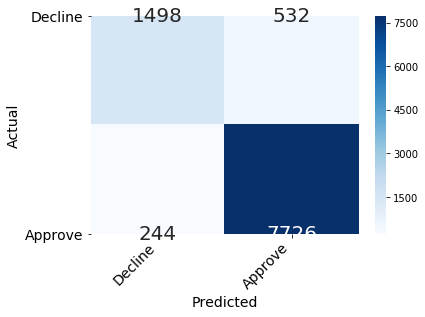

In [56]:
#accuracy score
print(accuracy_score(y_test, y_pred))

#confusion matrix
con_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix_df = pd.DataFrame(con_matrix, ('Decline', 'Approve'), ('Decline', 'Approve'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

#precision, recall and f1-score
print(classification_report(y_test, y_pred))

Recall Test: 0.97 Train: 0.97
Precision Test: 0.94 Train: 0.94
Roc Test: 0.96 Train: 0.97


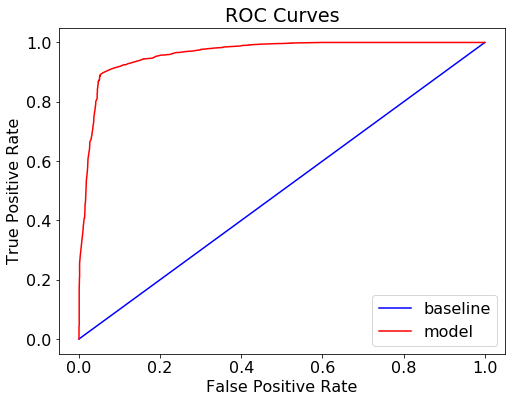

In [57]:
# Evaluating model performance unsing AUC
train_probs = adb_clf.predict_proba(X_train)[:, 1]
probs = adb_clf.predict_proba(X_test)[:, 1]
train_predictions = adb_clf.predict(X_train)
predictions = adb_clf.predict(X_test)
ada_AUC=roc_auc_score(y_test, probs)

evaluate_model(predictions, probs, train_predictions, train_probs)

## Stochastic Gradient Boosting (for Annualized Returns)

In [58]:
xVar = data.columns
xVar = xVar.drop(['loan_status', 'returns', 'installments_and_terms', 'annualized_returns'])

X = data.loc[:, xVar]
y = data.annualized_returns

#used to get dummy variables
X = pd.get_dummies(X)

In [59]:
#train/test split cell
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

#remove random state eventually

In [60]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

sgbt = GradientBoostingRegressor(
    max_depth=1
    , subsample=0.33
    , max_features=0.67
    , n_estimators=100
#     , random_state=42
)
sgbt.fit(X_train, y_train)

# Predict the test set labels
y_pred = sgbt.predict(X_test)

# Evaluate test set RMSE 'rmse_test'
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print 'rmse_test'
print('Test set RMSE: {:.2f}'.format(rmse_test))

Test set RMSE: 5855.36


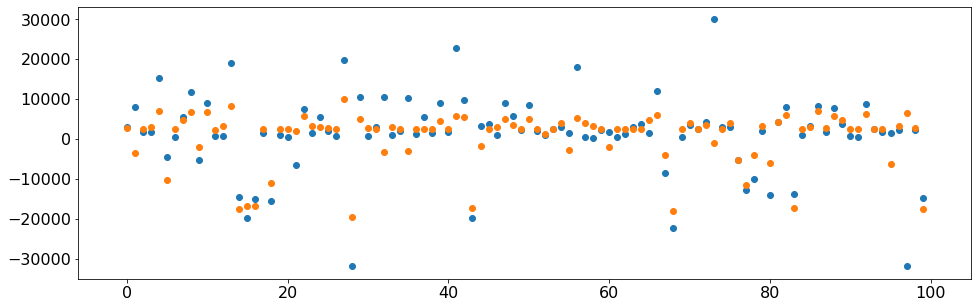

In [61]:
limit = 100 #max = 10000

x = np.arange(len(y_test))[:limit]
# y_test.values.tolist()

plt.scatter(x, y_test[:limit])
plt.scatter(x, y_pred[:limit])

fig = plt.gcf()
fig.set_size_inches(16,5)

plt.show()

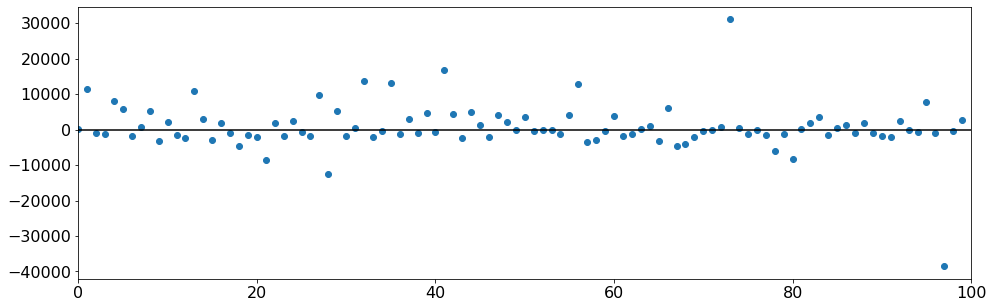

In [62]:
#showing the difference plotted instead of each variable
limit = 100 #max = 10000

x = np.arange(len(y_test))[:limit]
y_plot = y_test-y_pred
# print(np.mean(y_plot))

plt.scatter(x, y_plot[:limit])
plt.hlines(0, xmin=0, xmax=limit)

plt.xlim(0,limit)

fig = plt.gcf()
fig.set_size_inches(16,5)

plt.show()

## Modeling with Percent Return

In [ ]:
data = df.copy().iloc[samples[1],:]
data['percent_return'] = data['annualized_returns']/data['loan_amnt']
xVar = data.columns
xVar = xVar.drop(['loan_status', 'returns', 'installments_and_terms', 'annualized_returns','percent_return'])
X = data.loc[:, xVar]
y = data.percent_return

#used to get dummy variables
X = pd.get_dummies(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

sgbt = GradientBoostingRegressor(
    max_depth=1
    , subsample=0.33
    , max_features=0.67
    , n_estimators=200
#     , random_state=42
)
sgbt.fit(X_train, y_train)

# Predict the test set labels
y_pred = sgbt.predict(X_test)

# Evaluate test set RMSE 'rmse_test'
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print 'rmse_test'
print('Test set RMSE: {:.2f}'.format(rmse_test))

In [ ]:

from sklearn import metrics, model_selection
def evaluate(y_test, y_pred):
    # this block of code returns all the metrics we are interested in 
    mse = metrics.mean_squared_error(y_test, y_pred)
    msa = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)

    print("Mean squared error: ", mse)
    print("Mean absolute error: ", msa)
    print("R^2 : ", r2)
    
    # this creates a chart plotting predicted and actual 
    plt.figure(figsize=(12,6))
    plt.scatter(y_test, y_pred)
    plt.xlabel("Percent Return: $y_i$")
    plt.ylabel("Predicted percent return: $\hat{y}_i$")
    plt.title("Percent Return vs Predicted Percent Return: $y_i$ vs $\hat{y}_i$")

In [ ]:
evaluate(y_test,y_pred)

In [ ]:
params = {'max_depth':[1], 'subsample':[0.33], 'max_features':[0.5,0.67], 'n_estimators':[100,200]}

# we then create a grid search object with our chosen model and paramters. 
grid = model_selection.GridSearchCV(sgbt, params, cv=10, iid=False)

# we fit our model to the data as before
grid.fit(X_train, y_train)

# one output of the grid search function is that we can get the best_estimator - the model and parameters that scored best on the training data - 
#  and save it as a new a model
best_model = grid.best_estimator_

# and use it to predict and evaluate as before
y_pred = best_model.predict(X_test)

evaluate(y_test, y_pred)

print(grid.best_params_)
print(grid.best_score_)

In [ ]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]

In [ ]:
!pip install xgboost

In [ ]:
import xgboost as xgb
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.01,
                max_depth = 10, colsample_bytree=0.5,min_child_weight=3, gamma = 0.2, n_estimators = 500)
xg_reg.fit(X_train, y_train)

# Predict the test set labels
y_pred = xg_reg.predict(X_test)

# Evaluate test set RMSE 'rmse_test'
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print 'rmse_test'
print('Test set RMSE: {:.2f}'.format(rmse_test))

In [ ]:
evaluate(y_test,y_pred)

In [ ]:
params = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

# we then create a grid search object with our chosen model and paramters. 
grid = model_selection.GridSearchCV(sgbt, params, cv=10, iid=False)

# we fit our model to the data as before
grid.fit(X_train, y_train)

# one output of the grid search function is that we can get the best_estimator - the model and parameters that scored best on the training data - 
#  and save it as a new a model
best_model = grid.best_estimator_

# and use it to predict and evaluate as before
y_pred = best_model.predict(X_test)

evaluate(y_test, y_pred)

print(grid.best_params_)
print(grid.best_score_)

In [ ]:
xgb.plot_importance(xg_reg,max_num_features=10)
plt.show()

## Model to Predict Percent Return on Fully Paid Loans

In [ ]:
data = df[df['loan_status']=='Fully Paid'].sample(50000)
data['percent_return'] = data['annualized_returns']/data['loan_amnt']
xVar = data.columns
xVar = xVar.drop(['loan_status', 'returns', 'installments_and_terms', 'annualized_returns','percent_return'])
X = data.loc[:, xVar]
y = data.percent_return

#used to get dummy variables
X = pd.get_dummies(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

In [ ]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]

In [ ]:
import xgboost as xgb
xg_reg2 = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.01,
                max_depth = 10, colsample_bytree=0.5,min_child_weight=3, gamma = 0.2, n_estimators = 500)
xg_reg2.fit(X_train, y_train)

# Predict the test set labels
y_pred = xg_reg2.predict(X_test)

# Evaluate test set RMSE 'rmse_test'
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print 'rmse_test'
print('Test set RMSE: {:.2f}'.format(rmse_test))

In [ ]:
evaluate(y_test,y_pred)

In [ ]:
xgb.plot_importance(xg_reg2,max_num_features=10)
plt.show()

## Model to Predict Percent Return on Defaulted Loans

In [ ]:
data = df[df['loan_status']=='Charged Off'].sample(50000)
data['percent_return'] = data['annualized_returns']/data['loan_amnt']
xVar = data.columns
xVar = xVar.drop(['loan_status', 'returns', 'installments_and_terms', 'annualized_returns','percent_return'])
X = data.loc[:, xVar]
y = data.percent_return

#used to get dummy variables
X = pd.get_dummies(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

In [ ]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]

In [ ]:
import xgboost as xgb
xg_reg3 = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.01,
                max_depth = 10, colsample_bytree=0.5,min_child_weight=3, gamma = 0.2, n_estimators = 500)
xg_reg3.fit(X_train, y_train)

# Predict the test set labels
y_pred = xg_reg3.predict(X_test)

# Evaluate test set RMSE 'rmse_test'
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print 'rmse_test'
print('Test set RMSE: {:.2f}'.format(rmse_test))

In [ ]:
evaluate(y_test,y_pred)

In [ ]:
xgb.plot_importance(xg_reg3,max_num_features=10)
plt.show()

## Comparison of 3 Strategies


adb_clf for classifying default

xg_reg for predicting return on all loans

xg_reg2 for predicting return on FP loans, xg_reg3 for predicting return on Defaulted loans

In [ ]:
data = pd.concat([df.copy().iloc[samples[2],:],df.copy().iloc[samples[3],:],df.copy().iloc[samples[4],:],])
data['percent_return'] = data['annualized_returns']/data['loan_amnt']
xVar = data.columns
xVar = xVar.drop(['loan_status', 'returns', 'installments_and_terms', 'annualized_returns','percent_return'])
X = data.loc[:, xVar]
X = pd.get_dummies(X)
y = data.percent_return

### Method 0: Random Sample of 1000 Loans (Result ~2% return)

In [ ]:
np.mean(y.sample(1000))

In [ ]:
plt.hist(y.sample(1000), bins=100)
plt.xlabel('Annual Return rate')
plt.ylabel('Loans per bin')
plt.title('Random Loan Return Distribution')

### Method 1: Using the Default Model (Result: ~15% Return)

In [ ]:
prediction1 = pd.DataFrame(adb_clf.predict_proba(X),columns=['Default','Fully Paid'])
prediction1['percent_return'] = y.values

# These are the loans we pick
prediction1.nlargest(1000,'Fully Paid')

In [ ]:
# Percent return by this strategy
np.mean(prediction1.nlargest(1000,'Fully Paid').percent_return)

In [ ]:
plt.hist(prediction1.nlargest(1000,'Fully Paid')['percent_return'], bins=100)
plt.xlabel('Annual Return rate')
plt.ylabel('Loans per bin')
plt.title('Default Model Profolio Return distribution')

### Method 2: Using the Return Model (Result: ~95% Return)

In [ ]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

In [ ]:
prediction2 = pd.DataFrame(xg_reg.predict(X),columns=['Predicted Return'])
prediction2['Actual Return'] = y.values
# These are the loans we pick
prediction2.nlargest(1000,'Predicted Return')

In [ ]:
np.mean(prediction2.nlargest(1000,'Predicted Return')['Actual Return'])

In [ ]:
plt.hist(prediction2.nlargest(1000,'Predicted Return')['Actual Return'], bins=100)
plt.xlabel('Annual Return rate')
plt.ylabel('Loans per bin')
plt.title('Return Model Profolio Return distribution')

### Method 3: Using the Combined Approach (Result: ~83% Return)

In [ ]:
prediction3 = pd.concat([pd.DataFrame(adb_clf.predict_proba(X),columns=['Default','Fully Paid']),
           pd.DataFrame(xg_reg2.predict(X),columns=['Fully Paid Predicted Return']),
          pd.DataFrame(xg_reg3.predict(X),columns=['Defaulted Predicted Return'])],axis=1)

In [ ]:
prediction3['Expected Return']=prediction3['Default']*prediction3['Defaulted Predicted Return']+prediction3['Fully Paid']*prediction3['Fully Paid Predicted Return']

prediction3['Actual Return'] = y.values

In [ ]:
# These are the loans we pick
prediction3.nlargest(1000,'Expected Return')

In [ ]:
np.mean(prediction3.nlargest(1000,'Expected Return')['Actual Return'])

In [ ]:
plt.hist(prediction3.nlargest(1000,'Expected Return')['Actual Return'], bins=100)
plt.xlabel('Annual Return rate')
plt.ylabel('Loans per bin')
plt.title('Combination Model Profolio Return distribution')

### Comparing 4 results

In [ ]:
my_dict = {'Default': prediction1.nlargest(1000,'Fully Paid')['percent_return'], 'Return': prediction2.nlargest(1000,'Predicted Return')['Actual Return'], 'Combined':prediction3.nlargest(1000,'Expected Return')['Actual Return']}

fig, ax = plt.subplots()
bplot = ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
ax.set_axisbelow(True)
ax.set_title('Comparison of Three Prediction Models')
ax.set_ylabel('Return Rate')

## Sentiment Analysis of Loan Industry: Pre & Post Corona Virus

These strategies are effective in predicting return and developing an investment strategy prior to 2020. However, with the COVID-19 crisis, the financial markets have taken a hit as economies have shut down. Our team utilized sentiment analysis on the loan industry between 2019 & 2020 to determine how sentiment of loans have changed over the course of the year. Through industry research, we know that many lending platforms are concerned with inability of customers to pay loans, accessibility to loans, and maintaining investor’s funds for lending. We decided to look at the industry as a whole rather than just analyzing sentiment on Lending Club because we found that on Twitter, people very infrequently talk about specific lending platforms, but rather generic loans. Additionally, we decided that the impact to loans would be felt universally, rather than varying by platform, so sentiment of the loan industry should be reflective of Lending Club. 

In [63]:
!pip install twitterscraper

In [64]:
from twitterscraper import query_tweets
import pandas as pd
import numpy as np
import datetime
import time

INFO: {'User-Agent': 'Opera/9.80 (X11; Linux i686; Ubuntu/14.10) Presto/2.12.388 Version/12.16'}


## Loan Industry

Below, we ran the TwitterScraper on tweets containing the keyword *loan* or *Loan*. We looked at the time period starting from February 29th to to April 30th. We chose this time period because the US began its shutdown in the beginning of March, so we decided to back track to the beginning of March to capture sentiment leading up to shutdown. 

For both 2019 & 2020, we pulled a selection of approximately 3000 tweets. We used this threshold just so the computers have enough capacity to scrape enough tweets for both years. 

### 2019 Tweets

In [65]:
kw_list = ['"loan" OR "Loan"']
begin = datetime.date(2019, 2, 28)
end = datetime.date(2019, 4, 30)
limit = 3000
lang = 'en'
poolsize = 5

In [66]:
if __name__ == '__main__':
    start_time = time.time()
    tweets = query_tweets(query=" OR ".join(kw_list),
                         begindate=begin,
                         enddate = end,
                         limit = limit,
                         lang = lang,
                         poolsize = poolsize,
                         )
print(str(len(tweets)) + " tweets scraped in " + str(round(time.time() - start_time, 2)) + " seconds ")

INFO: queries: ['"loan" OR "Loan" since:2019-02-28 until:2019-03-12', '"loan" OR "Loan" since:2019-03-12 until:2019-03-24', '"loan" OR "Loan" since:2019-03-24 until:2019-04-05', '"loan" OR "Loan" since:2019-04-05 until:2019-04-17', '"loan" OR "Loan" since:2019-04-17 until:2019-04-30']
INFO: Querying "loan" OR "Loan" since:2019-03-24 until:2019-04-05
INFO: Querying "loan" OR "Loan" since:2019-03-12 until:2019-03-24
INFO: Querying "loan" OR "Loan" since:2019-02-28 until:2019-03-12
INFO: Querying "loan" OR "Loan" since:2019-04-05 until:2019-04-17
INFO: Scraping tweets from https://twitter.com/search?f=tweets&vertical=default&q="loan"%20OR%20"Loan"%20since%3A2019-03-12%20until%3A2019-03-24&l=en
INFO: Scraping tweets from https://twitter.com/search?f=tweets&vertical=default&q="loan"%20OR%20"Loan"%20since%3A2019-02-28%20until%3A2019-03-12&l=en
INFO: Querying "loan" OR "Loan" since:2019-04-17 until:2019-04-30
INFO: Scraping tweets from https://twitter.com/search?f=tweets&vertical=default&q="l

INFO: Using proxy 88.99.10.253:1080
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgKGVuKvelR8WgoCh-d7W35UfEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2019-04-17%20until%3A2019-04-30&l=en
INFO: Using proxy 103.105.77.19:8080
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgKfB1p6M5h4WgICrobKijuYeEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2019-03-12%20until%3A2019-03-24&l=en
INFO: Using proxy 103.105.77.19:8080
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgL_5pLXT1h4WgICnwdfd1NYeEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since

INFO: Using proxy 176.28.75.193:34922
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgKfdzoCK5h4WgICrobKijuYeEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2019-03-12%20until%3A2019-03-24&l=en
INFO: Using proxy 183.88.192.44:8080
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaEwKCB4__clR8WgoCh-d7W35UfEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2019-04-17%20until%3A2019-04-30&l=en
INFO: Using proxy 183.88.192.44:8080
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaKgLDN7uT-hB8WgIC3oZmrgYUfEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20sin

INFO: Using proxy 186.0.176.147:80
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgLbJ5rfD9R4WgoC_ieHhx_UeEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2019-03-24%20until%3A2019-04-05&l=en
INFO: Using proxy 186.0.176.147:80
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaIgLCZrrXblR8WgoCh-d7W35UfEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2019-04-17%20until%3A2019-04-30&l=en
INFO: Using proxy 103.57.71.137:33458
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaCgL-ByvrQ1h4WgICnwdfd1NYeEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3

INFO: Using proxy 95.58.161.180:48021
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgL39nov8hB8WgIC3oZmrgYUfEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2019-04-05%20until%3A2019-04-17&l=en
INFO: Using proxy 158.140.167.148:53281
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaEwLSRlOPB9R4WgoC_ieHhx_UeEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2019-03-24%20until%3A2019-04-05&l=en
INFO: Using proxy 95.58.161.180:48021
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgLbhmun7hB8WgIC3oZmrgYUfEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%2

INFO: Using proxy 134.249.167.184:53281
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaCwLWB5bX6hB8WgIC3oZmrgYUfEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2019-04-05%20until%3A2019-04-17&l=en
INFO: Using proxy 134.249.167.184:53281
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgL3t7bjA9R4WgoC_ieHhx_UeEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2019-03-24%20until%3A2019-04-05&l=en
INFO: Using proxy 134.249.167.184:53281
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaKwLuZk6aE5h4WgICrobKijuYeEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loa

INFO: Using proxy 119.81.199.81:8123
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaOgL_JmojO1h4WgICnwdfd1NYeEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2019-02-28%20until%3A2019-03-12&l=en
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgLaN7LL4hB8WgIC3oZmrgYUfEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2019-04-05%20until%3A2019-04-17&l=en
INFO: Using proxy 142.93.4.1:3128
INFO: Using proxy 46.235.53.26:3128
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAwLSh_92-9R4WgoC_ieHhx_UeEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A

3074 tweets scraped in 64.06 seconds 


In [67]:
tweets2019_df = pd.DataFrame(columns = ['timestamp', 'username', 'user_id', 'tweet_id',
                                   'text', 'likes', 'replies', 'retweets', 'tweet_url', 'parent_tweet_id'])

In [68]:
for tweet in tweets:
    tweets2019_df = tweets2019_df.append({
        'timestamp': tweet.timestamp,
        'username': tweet.username,
        'screen_name': tweet.screen_name,
        'user_id': tweet.user_id,
        'tweet_id': tweet.tweet_id,
        'text': tweet.text,
        'likes': tweet.likes,
        'replies': tweet.replies,
        'retweets': tweet.retweets,
        'tweet_url': tweet.tweet_url,
        'parent_tweet_id': tweet.parent_tweet_id}, ignore_index=True)
    
import gc
del tweets
gc.collect()

0

In [69]:
tweets2019_df.tail(25)

,timestamp,username,user_id,tweet_id,text,likes,replies,retweets,tweet_url,parent_tweet_id,screen_name
3049,2019-03-11 22:50:43,Cıarannn!🤘🏻,419050834,1105239657443454976,Loan? What is the actual point.,0,0,0,/VaaalkY/status/1105239657443454976,1105237664721235969,VaaalkY
3050,2019-03-11 22:50:33,みんなのエコ宣言プロジェクト,854303124831346688,1105239616209137664,"Payday Loans \n\n<a href=""http://loansforbadcr...",0,0,0,/tottorieco/status/1105239616209137664,,tottorieco
3051,2019-03-11 22:50:30,The Sun Football ⚽,20689749,1105239603391406080,Sanchez could leave Man Utd on loan next seaso...,14,0,5,/TheSunFootball/status/1105239603391406080,,TheSunFootball
3052,2019-03-11 22:50:24,Jabari,42415376,1105239578762448896,Entrepreneurship is long nights grinding just ...,0,0,1,/jabari53/status/1105239578762448896,1104766943029018624,jabari53
3053,2019-03-11 22:50:15,Francis Wu,7768222,1105239541663887366,"""Master’s and doctorate degrees often lead to ...",0,0,0,/thisisfranciswu/status/1105239541663887366,,thisisfranciswu
3054,2019-03-11 22:50:14,Stephanie Mellor,983684286,1105239537914167297,Keeping on top of credit card and #loan paymen...,0,0,0,/goforsteph/status/1105239537914167297,,goforsteph
3055,2019-03-11 22:50:03,HOMTV,39496867,1105239489813929984,Join us LIVE for a new episode of Open Line di...,0,0,1,/HOMTV/status/1105239489813929984,,HOMTV
3056,2019-03-11 22:50:00,Jabari,42415376,1105239475783954432,Entrepreneurship is long nights grinding just ...,1,0,2,/jabari53/status/1105239475783954432,,jabari53
3057,2019-03-11 22:49:58,Harry,848595653286658048,1105239467726655488,Firstly it’s the sun so it’s automatically non...,1,0,0,/HarryMufc97/status/1105239467726655488,1105237664721235969,HarryMufc97
3058,2019-03-11 22:49:54,Anis Ahmed,249574372,1105239451180191745,Loan?\nWell that Chairman please!,0,0,0,/anis__aa/status/1105239451180191745,1105237664721235969,anis__aa


In [70]:
tweets2019_df.text.to_csv("2019_texts.csv", index=False, header=False, sep='\t', encoding='utf-16')

In [71]:
tweets2019_df.to_csv("2019TwitterScraper.csv", index = False)

We are saving the 2019 tweets to their own csv so we can separate 2019 & 2020 when analyzing impacts of the coronavirus. 

### 2020 Tweets

In [72]:
from twitterscraper import query_tweets
kw_list = ['"loan" OR "Loan"']
begin = datetime.date(2020, 2, 27)
end = datetime.date(2020, 4, 30)
limit = 3000
lang = 'en'
poolsize = 5

if __name__ == '__main__':
    start_time = time.time()
    tweets = query_tweets(query=" OR ".join(kw_list),
                         begindate = begin,
                         enddate = end,
                         limit = limit,
                         lang = lang,
                         poolsize = poolsize,
                         )
display(str(len(tweets)) + " tweets scraped in " + str(round(time.time() - start_time, 2)) + " seconds")

tweets2020_df = pd.DataFrame(columns = ['timestamp', 'username', 'screen_name', 'user_id', 'tweet_id',
                                    'text', 'likes', 'replies', 'retweets', 'tweets_url', 'parent_tweet_id'])

for tweet in tweets: 
    tweets2020_df = tweets2020_df.append({
        'timestamp': tweet.timestamp,
        'username': tweet.username,
        'screen_name': tweet.screen_name,
        'user_id': tweet.user_id,
        'tweet_id': tweet.tweet_id,
        'text': tweet.text,
        'likes': tweet.likes,
        'replies': tweet.replies,
        'retweets': tweet.retweets, 
        'parent_tweet_id': tweet.parent_tweet_id}, ignore_index=True)
    
import gc
del tweets
gc.collect()

INFO: queries: ['"loan" OR "Loan" since:2020-02-27 until:2020-03-10', '"loan" OR "Loan" since:2020-03-10 until:2020-03-23', '"loan" OR "Loan" since:2020-03-23 until:2020-04-04', '"loan" OR "Loan" since:2020-04-04 until:2020-04-17', '"loan" OR "Loan" since:2020-04-17 until:2020-04-30']
INFO: Querying "loan" OR "Loan" since:2020-04-04 until:2020-04-17
INFO: Querying "loan" OR "Loan" since:2020-03-10 until:2020-03-23
INFO: Querying "loan" OR "Loan" since:2020-03-23 until:2020-04-04
INFO: Querying "loan" OR "Loan" since:2020-02-27 until:2020-03-10
INFO: Scraping tweets from https://twitter.com/search?f=tweets&vertical=default&q="loan"%20OR%20"Loan"%20since%3A2020-03-23%20until%3A2020-04-04&l=en
INFO: Scraping tweets from https://twitter.com/search?f=tweets&vertical=default&q="loan"%20OR%20"Loan"%20since%3A2020-04-04%20until%3A2020-04-17&l=en
INFO: Scraping tweets from https://twitter.com/search?f=tweets&vertical=default&q="loan"%20OR%20"Loan"%20since%3A2020-03-10%20until%3A2020-03-23&l=en


INFO: Using proxy 88.99.10.253:1080
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaCwKfZ5c-9yyIWgIC1ran6vcsiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2020-03-23%20until%3A2020-04-04&l=en
INFO: Using proxy 103.105.77.19:8080
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAwLyNibOlqyIWgoC1pcGKpqsiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2020-02-27%20until%3A2020-03-10&l=en
INFO: Using proxy 103.105.77.19:8080
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaCgKOxhqL67CIWgsC13bjO-uwiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since

INFO: Using proxy 176.28.75.193:34922
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAwKGV2M-b3CIWgoC8vdajnNwiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2020-04-04%20until%3A2020-04-17&l=en
INFO: Using proxy 176.28.75.193:34922
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaCgLXNstukqyIWgoC1pcGKpqsiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2020-02-27%20until%3A2020-03-10&l=en
INFO: Using proxy 176.28.75.193:34922
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgKexioy9yyIWgIC1ran6vcsiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20s

INFO: Using proxy 186.0.176.147:80
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAwKO52ta8yyIWgIC1ran6vcsiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2020-03-23%20until%3A2020-04-04&l=en
INFO: Using proxy 212.57.22.178:8080
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAwKP5s5mb3CIWgoC8vdajnNwiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2020-04-04%20until%3A2020-04-17&l=en
INFO: Using proxy 186.0.176.147:80
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaCgLqxxreDvCIWhICwqdS1hLwiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A

INFO: Using proxy 95.58.161.180:48021
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgKfN3rC8yyIWgIC1ran6vcsiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2020-03-23%20until%3A2020-04-04&l=en
INFO: Using proxy 117.58.241.164:52636
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAwLy5gpaDvCIWhICwqdS1hLwiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2020-03-10%20until%3A2020-03-23&l=en
INFO: Using proxy 95.58.161.180:48021
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAgLvloeOa3CIWgoC8vdajnNwiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20

INFO: Using proxy 201.55.160.99:3128
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaMgLq1trqa3CIWgoC8vdajnNwiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2020-04-04%20until%3A2020-04-17&l=en
INFO: Using proxy 201.55.160.99:3128
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaCgLudw_KCvCIWhICwqdS1hLwiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2020-03-10%20until%3A2020-03-23&l=en
INFO: Using proxy 201.55.160.99:3128
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaEgLWFvPW7yyIWgIC1ran6vcsiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20sinc

INFO: Using proxy 190.114.253.18:8080
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaCwL3h9oSa3CIWgoC8vdajnNwiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2020-04-04%20until%3A2020-04-17&l=en
INFO: Using proxy 88.198.24.108:8080
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAwL6hoLKhqyIWgoC1pcGKpqsiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20since%3A2020-02-27%20until%3A2020-03-10&l=en
INFO: Using proxy 88.198.24.108:8080
INFO: Scraping tweets from https://twitter.com/i/search/timeline?f=tweets&vertical=default&include_available_features=1&include_entities=1&reset_error_state=false&src=typd&max_position=thGAVUV0VFVBaAwLSN7ce7yyIWgIC1ran6vcsiEjUAFQAlAFUAFQAA&q="loan"%20OR%20"Loan"%20sin

'3066 tweets scraped in 67.01 seconds'

0

In [73]:
tweets2020_df.text.to_csv("2020_texts.csv", index=False, header=False, sep='\t', encoding='utf-16')

In [74]:
tweets2020_df.to_csv("2020TwitterScraper.csv", index=False)

### 2019 & 2020 Tweets

Now, we concatenate the two datasets into one and we will start some time series visualization 

In [75]:
tweets_df = pd.concat([tweets2019_df, tweets2020_df], axis=0)

tweets_df.shape

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(6140, 12)

One mistake that we noticed was that after concatenating the datasets into one set, the indices did not reset and each number was double counted with a tweet from 2019 & a tweet from 2020, as you can see below. 

In [77]:
for i in range(0,12):
    print(tweets_df.text[i])
    print('\n')

0    and who can afford an EV? a compact or sub com...
0    #bankofamerica is prioritizing Paycheck suppor...
Name: text, dtype: object


1    Leica lent me their newest M for a short while...
1    @PNCBank_Help @PNCBank @stevenmnuchin1 @realDo...
Name: text, dtype: object


2    @MTNGhana continue stealing my airtime and dat...
2    $350B sham! Money is only going to existing bo...
Name: text, dtype: object


3    Best loan we've ever had. You got us in with a...
3    These are the conversations we need to have no...
Name: text, dtype: object


4    Oh same as my current one "baby I got student ...
4    Disgraced Obama sycophant Scott Wapner got emb...
Name: text, dtype: object


5    @SophyRidgeSky ask that tory git about #edm123...
5    Non uni students think student loan like winni...
Name: text, dtype: object


6    Planning another move? If you've already used ...
6    Default Trump Jr. says what?\n\nTrump Org asks...
Name: text, dtype: object


7            Momma needs some coll

To fix this issue, we just reset the indices of the merged set. 

In [80]:
tweets_df.reset_index(inplace=True)

### Save tweets to CSV

In [78]:
tweets_df.text.to_csv('tweet_texts.csv',index=False, header=False, sep='\t', encoding= 'utf-16')

In [79]:
tweets_df.to_csv("LCTwitterScraper.csv", index = False)

### Sentiment Analysis

Now is time for the sentiment analysis. First, we installed the sentiment analysis tool and stripped the tweets down to remove any non-text language that are unfamiliar to the sentiment analysis tool. These include #, @, RE, and, FAV. 

In [81]:
!pip install vaderSentiment

In [82]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

In [83]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    print("{:-<55} {}".format(sentence, str(score)), "\n")

After removing these characters, the tweets are much more machine readable. 

In [84]:
#import regular expressions
import re

#Set-up patterns to be removed for the tweets
pat1 = r"https\S+"
pat2 = r"#"
pat3 = r"@"
pat4 = r"FAV"
pat5 = r"RE"
pat6 = r"pic.\S+"
combined_pat = r'|'.join((pat1, pat2, pat3, pat4, pat5, pat6))


#replace the patterns with an empty string
tweets_df['stripped'] = [re.sub(combined_pat, '', w) for w in tweets_df.text]

#might have double spaces now (because of empty string replacements above) - remove double spaces
tweets_df['stripped'] = [re.sub(r"  ", ' ', w) for w in tweets_df.loc[:,'stripped']]

#Print tweets
for i in range(0,12):
    print(tweets_df.stripped[i])
    print('\n')


and who can afford an EV? a compact or sub compact gas model is 20-30k less. EV's start about $45k. one twit said he saved $1500 per year. thats a long payback not to mention qualifying for a $45k car loan.


Leica lent me their newest M for a short while. Had it for about a month while working on assignment. The size is very close to my M6. I really didn't want to give it back. Fuji's XPro2 is great in the hand. That's my go-to camera for now, until a Leica loan becomes indefinite..!


MTNGhana continue stealing my airtime and data okay the day I go take quick loan of 2k plus dont think of me paying back s)))))))))


Best loan we've ever had. You got us in with a chance and no doubt you'll do everything to keep us in with a chance. You can do no wrong between now and the end of the season.


Oh same as my current one "baby I got student loans to pay"


SophyRidgeSky ask that tory git about edm1239 and he and Mel strides and Jon Thomson being in cahoots to Rob and steal from 100000 +pe

In the block of code below, we tested the seniment analysis tool on the first tweet in the set. Unforunately, this tweet is nonsensical, so the sentence is rated as entirely **neutral**. 

In [85]:
# Text how well Vader does
my_tweet = tweets_df.iloc[0,5]
sentiment_analyzer_scores(str(my_tweet))

# Print individual polarity scores
sentiment_dict = analyser.polarity_scores(my_tweet)
print("Compound sentiment is", sentiment_dict['compound'], "\n")
print("Sentence was rated as", sentiment_dict['neg']*100, "% Negative")
print("Sentence was rated as", sentiment_dict['neu']*100, "% Neutrality")
print("Sentence was rated as", sentiment_dict['pos']*100, "% Positive")

EricGus45287870---------------------------------------- {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0} 

Compound sentiment is 0.0 

Sentence was rated as 0.0 % Negative
Sentence was rated as 100.0 % Neutrality
Sentence was rated as 0.0 % Positive


However, based on the output below, when looking at the last 50 tweets, the sentiment analysis tool works well with classifying the overall negativity/positivity of each tweet.

In [86]:
# Import the sentiment module (if you haven't already done so)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Import numpy (if you have not already done so)
import numpy as np

# Instantiate the sentiment analyzer (if you haven't already done so)
analyser = SentimentIntensityAnalyzer()

# Now get the compound sentiment score for each tweet
tweets_df['C_Score'] = np.nan
for index, row in tweets_df.iterrows(): 
    tweets_df.loc[index, 'C_Score'] = analyser.polarity_scores(row['stripped'])['compound']
# Let's take a look!
pd.set_option('display.max_colwidth', -1)
tweets_df[['stripped','C_Score']].head(-50)

,stripped,C_Score
0,and who can afford an EV? a compact or sub compact gas model is 20-30k less. EV's start about $45k. one twit said he saved $1500 per year. thats a long payback not to mention qualifying for a $45k car loan.,0.4215
1,"Leica lent me their newest M for a short while. Had it for about a month while working on assignment. The size is very close to my M6. I really didn't want to give it back. Fuji's XPro2 is great in the hand. That's my go-to camera for now, until a Leica loan becomes indefinite..!",0.7959
2,MTNGhana continue stealing my airtime and data okay the day I go take quick loan of 2k plus dont think of me paying back s))))))))),-0.4215
3,Best loan we've ever had. You got us in with a chance and no doubt you'll do everything to keep us in with a chance. You can do no wrong between now and the end of the season.,0.8971
4,"Oh same as my current one ""baby I got student loans to pay""",-0.1027
...,...,...
6085,Ask him if he's here to pay off his loans.,-0.1027
6086,"The US Small Business Administration is offering a low-interest loans to help small business owners meet financial obligations, cover operating expenses, & alleviate economic injury caused by COVID-19. … this may help some small physician practices covid19",0.3818
6087,"JeffreeStar pulte I’m a college student paying for school completely in loans. I live on campus, but in this insane time they’ve asked us to stay home, but won’t refund any housing money. The money would really help! …",-0.1255
6088,"$halleycat79 is my cash app, ready when you are! That could greatly help my student loan debt, I graduate in a few months! Thanks for the chance! …",0.8303


Overall, vaderSentiment classified all 6140 tweets, with 2906 as positive, 1981 as negative, and 1253 as neutral. 

In [87]:
import pandas as pd
import numpy as np

print(f"Count positive tweets: {sum(tweets_df['C_Score'] > 0.05)}")
print(f"Count neutral tweets: {tweets_df['C_Score'].between(-0.05, 0.05).sum()}")
print(f"Count negative tweets: {sum(tweets_df['C_Score'] < -0.05)}")
print(f"Total number of tweets: {tweets_df['C_Score'].count()}")
      
display(tweets_df.C_Score.describe())

Count positive tweets: 2906
Count neutral tweets: 1253
Count negative tweets: 1981
Total number of tweets: 6140


count    6140.000000
mean     0.104434   
std      0.480504   
min     -0.983600   
25%     -0.202925   
50%      0.000000   
75%      0.504000   
max      0.977400   
Name: C_Score, dtype: float64

### Visualize Sentiment

Based on the graph below, the overall sentiment for loans is skewed positively. Perhaps this is from the lack of negativity in 2019 or those who are having frustrations with their loans are not readily tweeting about these issues. 

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Sentiment Distribution')]

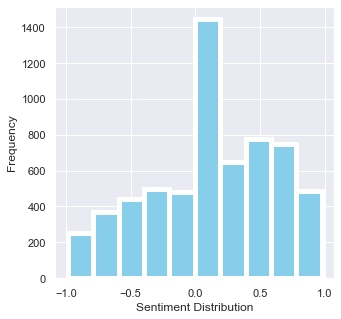

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True)

sns.set(rc={'figure.figsize':(5,5)})

# Create Histogram
ax = sns.distplot(tweets_df['C_Score'],
                 bins=10,
                 kde=False,
                 color='skyblue',
                 hist_kws={"linewidth":5, 'alpha':1})
ax.set(xlabel='Sentiment Distribution', ylabel='Frequency')

### Create Sentiment Column

Now, we are creating a sentiment that takes the numerical C_Score variable and converts it into a categorical column labeled **Sentiment**. 

In [89]:
print(type(tweets_df))

<class 'pandas.core.frame.DataFrame'>


In [90]:
# create new column
tweets_df['Sentiment'] = np.nan

# Loop through rows of dataframe and determine strings for new column "Sentiment"
for index, row in tweets_df.iterrows(): 
    if tweets_df.loc[index, 'C_Score'] > 0.05 : 
            tweets_df.loc[index, 'Sentiment'] = "Positive"       
    elif tweets_df.loc[index, 'C_Score'] < -0.05 :
            tweets_df.loc[index, 'Sentiment'] = "Negative"   
    else : 
        tweets_df.loc[index, 'Sentiment'] = "Neutral"

In [91]:
tweets_df[['stripped', 'C_Score', 'Sentiment']].head(40)

,stripped,C_Score,Sentiment
0,and who can afford an EV? a compact or sub compact gas model is 20-30k less. EV's start about $45k. one twit said he saved $1500 per year. thats a long payback not to mention qualifying for a $45k car loan.,0.4215,Positive
1,"Leica lent me their newest M for a short while. Had it for about a month while working on assignment. The size is very close to my M6. I really didn't want to give it back. Fuji's XPro2 is great in the hand. That's my go-to camera for now, until a Leica loan becomes indefinite..!",0.7959,Positive
2,MTNGhana continue stealing my airtime and data okay the day I go take quick loan of 2k plus dont think of me paying back s))))))))),-0.4215,Negative
3,Best loan we've ever had. You got us in with a chance and no doubt you'll do everything to keep us in with a chance. You can do no wrong between now and the end of the season.,0.8971,Positive
4,"Oh same as my current one ""baby I got student loans to pay""",-0.1027,Negative
5,SophyRidgeSky ask that tory git about edm1239 and he and Mel strides and Jon Thomson being in cahoots to Rob and steal from 100000 +people hit by the heinous loan charge 2019. Its a Retrospective tax going back 20 years,-0.7783,Negative
6,"Planning another move? If you've already used your VA Home Loan, you can restore it in full Here's how:",0.2960,Positive
7,Momma needs some college loans paid off!!,0.0000,Neutral
8,I need a small loan of 2 mil. Nothing crazy.,0.2584,Positive
9,"I entered the $5,000 Discover Student Loans Scholarship Award sweepstakes for college. Enter today for a chance to win! I can get a bonus entry when you sign up. No purchase or loan necessary. …",0.8977,Positive


### More Sentiment Visualization

With this new *sentiment* column, we created a pie chart visualization which shows that about half of the tweets in 2019 & 2020 are positive, and only 32% are negative. This is less than we as a team anticipated, simply because in the news and online, there are plenty of articles depicting the struggles many people have with loans, specifically with our interaction with students and student loans.

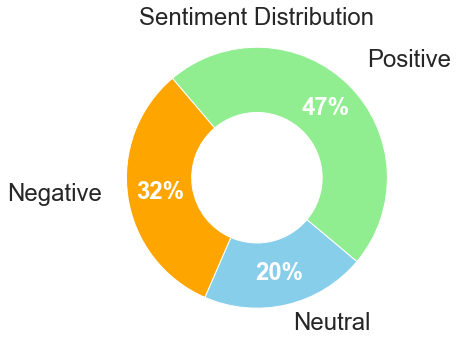

In [92]:
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 24

# Define figure
fig, ax = plt.subplots(figsize=(9, 6), subplot_kw=dict(aspect="equal"))

# Get count by sentiment category from tweets_df
sentiment_counts = tweets_df.Sentiment.value_counts()
labels = sentiment_counts.index

color_palette_list = ['lightgreen', 'orange', 'skyblue']

# Generate graph components
wedges, texts, autotexts = ax.pie(sentiment_counts, wedgeprops=dict(width=0.5), startangle=-40,
                                 colors=color_palette_list[0:3], autopct='%1.0f%%', pctdistance=.75, textprops={'color':"w", 'weight':'bold'})

# Plot wedges
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0, angleB={}".format(ang)
    ax.annotate(labels[i], xy=(x, y), xytext=(1.2*x, 1.2*y),
                horizontalalignment=horizontalalignment)

ax.set_title("Sentiment Distribution", y=.95, fontsize = 24)


plt.show()

Below is a time series distribution of how sentiment changed between 2019 & 2020. This is surprising to our team. As the economy worsens, people are losing jobs, and therefore accessibility to funds to pay off loans. Additionally, the government is working to maintain accessibility to loans for people in need, however the rules and restrictions to these measures are a cause of frustration for many. However, this does not seem to be heavily reflected in a change in sentiment between 2019 & 2020. Perhaps, amidst the frustrations and concerns of financial access, the number of firms and the government actively stepping in to help people is mitigating these concerns. For instance, the government developed the CARES act, which has 4 components that help different areas of the economy stay afloat during this crisis.

Even though the sentiment remains fairly consistent, our team noticed some differentiation in the word clouds of 2019 & 2020, showcasing that although the overall sentiment is stationary, the types of concerns have adjusted. 

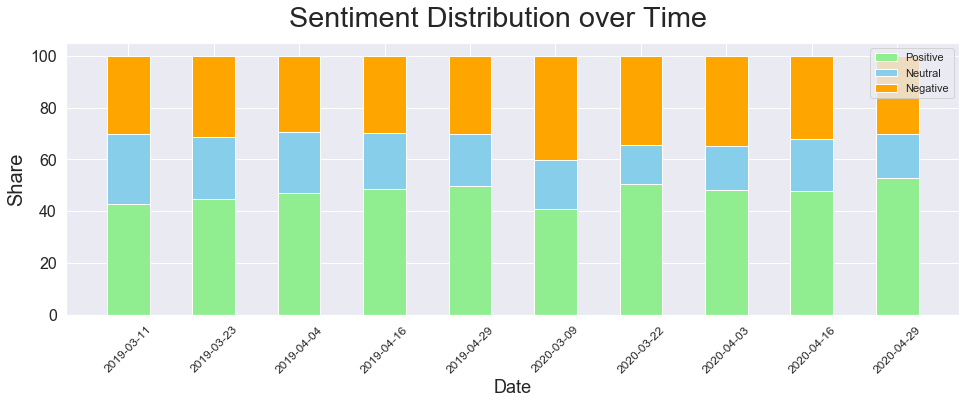

In [93]:
import math
tweets_df['date'] = [one.date() for one in tweets_df['timestamp']]
tweets_df = tweets_df.sort_values(by=['date'])

sentiments = ["Positive", "Neutral", "Negative"]
positiveProps = (tweets_df[tweets_df.Sentiment == 'Positive'].groupby(['date']).count()[['Sentiment']]/ tweets_df.groupby(['date']).count()[['Sentiment']])*100
neutralProps = (tweets_df[tweets_df.Sentiment == 'Neutral'].groupby(['date']).count()[['Sentiment']]/ tweets_df.groupby(['date']).count()[['Sentiment']])*100
negativeProps = (tweets_df[tweets_df.Sentiment == 'Negative'].groupby(['date']).count()[['Sentiment']]/ tweets_df.groupby(['date']).count()[['Sentiment']])*100
 
positiveProps = positiveProps['Sentiment'].tolist()
neutralProps = neutralProps['Sentiment'].tolist()
negativeProps = negativeProps['Sentiment'].tolist()
plt.figure(figsize=[16, 5])
barWidth = 0.5
labels = tweets_df.date.unique()
r = np.arange(len(labels))
positiveProps = [0 if math.isnan(x) else x for x in positiveProps]
neutralProps = [0 if math.isnan(x) else x for x in neutralProps]
negativeProps = [0 if math.isnan(x) else x for x in negativeProps]

plt.bar(r,positiveProps, color='lightgreen', edgecolor='white', width=barWidth)
plt.bar(r, neutralProps, bottom=positiveProps, color='skyblue', edgecolor='white', width=barWidth)
plt.bar(r, negativeProps, bottom=[i+j for i,j in zip(positiveProps, neutralProps)], color='orange', edgecolor='white', width=barWidth)
 
plt.xticks(r, labels, rotation = 45, fontsize=12)
plt.yticks(fontsize=16)
plt.suptitle('Sentiment Distribution over Time')
plt.xlabel("Date", fontsize=18)
plt.ylabel("Share", fontsize=20)
plt.legend(sentiments)
plt.show()

### 2019 & 2020 Word Clouds

In order to develop these word clouds, we first needed to tokenize the tweets to determine which words occur mst frequently. In this section, we separated the data sets in 2019 & 2020 sets for comparison. 

The steps of processing include, removing unfamiliar regular expressions, creating *C_Score* and *Sentiment* columns, tokenizing the tweets, and stemming & lemmatizing the tweets. 

In [94]:
#import regular expressions
import re

#Set-up patterns to be removed for the tweets
pat1 = r"https\S+"
pat2 = r"#"
pat3 = r"@"
pat4 = r"FAV"
pat5 = r"RE"
pat6 = r"pic.\S+"
combined_pat = r'|'.join((pat1, pat2, pat3, pat4, pat5, pat6))


# 2019
# replace the patterns with an empty string
tweets2019_df['stripped'] = [re.sub(combined_pat, '', w) for w in tweets2019_df.text]

#might have double spaces now (because of empty string replacements above) - remove double spaces
tweets2019_df['stripped'] = [re.sub(r"  ", ' ', w) for w in tweets2019_df.loc[:,'stripped']]

    
    
# 2020
# replace the patterns with an empty string
tweets2020_df['stripped'] = [re.sub(combined_pat, '', w) for w in tweets2020_df.text]

#might have double spaces now (because of empty string replacements above) - remove double spaces
tweets2020_df['stripped'] = [re.sub(r"  ", ' ', w) for w in tweets2020_df.loc[:,'stripped']]



In [95]:
# Import the sentiment module (if you haven't already done so)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Import numpy (if you have not already done so)
import numpy as np

# Instantiate the sentiment analyzer (if you haven't already done so)
analyser = SentimentIntensityAnalyzer()


# 2019
# Now get the compound sentiment score for each tweet
tweets2019_df['C_Score'] = np.nan
for index, row in tweets2019_df.iterrows(): 
    tweets2019_df.loc[index, 'C_Score'] = analyser.polarity_scores(row['stripped'])['compound']
# Let's take a look!


# 2020
# Now get the compound sentiment score for each tweet
tweets2020_df['C_Score'] = np.nan
for index, row in tweets2020_df.iterrows(): 
    tweets2020_df.loc[index, 'C_Score'] = analyser.polarity_scores(row['stripped'])['compound']
# Let's take a look!

In [96]:
# 2019
tweets2019_df['Sentiment'] = np.nan

# Loop through rows of dataframe and determine strings for new columns
for index, row in tweets2019_df.iterrows():
    if tweets2019_df.loc[index, 'C_Score'] > 0.05 :
        tweets2019_df.loc[index, 'Sentiment'] = "Positive"
    elif tweets2019_df.loc[index, 'C_Score'] < -0.05 : 
        tweets2019_df.loc[index, 'Sentiment'] = "Negative"
    else :
        tweets2019_df.loc[index, 'Sentiment'] = "Neutral"
        
        
# 2020
tweets2020_df['Sentiment'] = np.nan

# Loop through rows of dataframe and determine strings for new columns
for index, row in tweets2020_df.iterrows():
    if tweets2020_df.loc[index, 'C_Score'] > 0.05 :
        tweets2020_df.loc[index, 'Sentiment'] = "Positive"
    elif tweets2020_df.loc[index, 'C_Score'] < -0.05 : 
        tweets2020_df.loc[index, 'Sentiment'] = "Negative"
    else :
        tweets2020_df.loc[index, 'Sentiment'] = "Neutral"

In [97]:
# 1. Start by importing the necessary modules
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

# 2019 tweets
tweets2019_df["Tokens"] = [[] for _ in range(len(tweets2019_df))]
tweets2019_df["CleanTweets"] = [[] for _ in range(len(tweets2019_df))]
#tweets_df['Tokens'] = tweets_df['Tokens'].astype('object')

for index, row in tweets2019_df.iterrows(): 
    tweets2019_df.at[index, 'Tokens'] = tknzr.tokenize(row['stripped'])
    
# 2020 tweets
tweets2020_df["Tokens"] = [[] for _ in range(len(tweets2020_df))]
tweets2020_df["CleanTweets"] = [[] for _ in range(len(tweets2020_df))]

for index, row in tweets2020_df.iterrows(): 
    tweets2020_df.at[index, 'Tokens'] = tknzr.tokenize(row['stripped'])

In [98]:
# 1. Start by importing required modules
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from nltk.stem import WordNetLemmatizer

# 2. Instantiate Stemmer
ps = PorterStemmer()
le = WordNetLemmatizer()

# 2019
# 3. Now clean tweets (stripped tweets!) one by one
for index, row in tweets2019_df.iterrows(): 
    # Remove Punctuation
    words = [w for w in row['Tokens']
        if w.isalpha()]  #returns "true" if string only includes alphabetical strings
    
    # Remove Stopwords
    words = [w for w in words
       if w not in stopwords.words('english')]

    # Stem or Lemmatize tokens
    #words = [ps.stem(w) for w in words]
    words = [le.lemmatize(w) for w in words]
      
    # Write cleaned list of tokens into cell
    tweets2019_df.at[index, 'Tokens'] = words

    # Put stems back into a sentence
    sentence = " ".join(token for token in words)

     # Write cleaned sentences into cell
    tweets2019_df.at[index, 'CleanTweets'] = sentence
        
# 4. Finally, check if it worked
tweets2019_df.Tokens.head(10)


# 2020
# 3. Now clean tweets (stripped tweets!) one by one
for index, row in tweets2020_df.iterrows(): 
    # Remove Punctuation
    words = [w for w in row['Tokens']
        if w.isalpha()]  #returns "true" if string only includes alphabetical strings
    
    # Remove Stopwords
    words = [w for w in words
       if w not in stopwords.words('english')]

    # Stem or Lemmatize tokens
    #words = [ps.stem(w) for w in words]
    words = [le.lemmatize(w) for w in words]
      
    # Write cleaned list of tokens into cell
    tweets2020_df.at[index, 'Tokens'] = words

    # Put stems back into a sentence
    sentence = " ".join(token for token in words)

     # Write cleaned sentences into cell
    tweets2020_df.at[index, 'CleanTweets'] = sentence
        
# 4. Finally, check if it worked
tweets2020_df.Tokens.head(10)

0    [bankofamerica, prioritizing, Paycheck, support, application, existing, borrower, first, opening, broadly, Fed, money, first, come, first, serve, Existing, BoA, borrower, get, relief, default, BoA, loan, BEFO, Fed, money, run, Self, dealing]
1    [PNCBank, stevenmnuchin, realDonaldTrump, PNC, website, state, PPP, We, Yet, cant, put, request, loan, u, My, commercial, account, PNC, yet, others, processing, PNC, giving, tag, line, Please, help]                                           
2    [sham, Money, going, existing, borrower, customer, loan, relationship, hence, bailing, bank, The, bank, said, touch, couple, week, I, submitted, request]                                                                                        
3    [These, conversation, need, Commercial, Banks, also, need, work, CBN, defer, loan, payment, enable, real, sector, recover, pandemic]                                                                                                             
4    [Disgra

In [99]:
!pip install wordcloud

The first wordcloud depicts the top negative words in the 2019 tweets. The key words we noticed are "credit", "cut", "debt", "mortgage application", "default", "student", etc. Basically, the common theme among these words seems to be focused on frustration with specific types of large loans, like mortgage and student. Additionally, the common concerns with loans arise, such as concerns with credit, default, and cutting payments. 

The second wordcloud depicts the top negative words in the 2020 tweets. The key words we noticed are "stimulus", "program", "Trump", "crisis", "scam", "unemployment". The concerns have switched from just the usual large loan frustrations to worries about accessibility to financial programs and economic disruption. The general theme of these negative words seem to be worry about unemployment and the current stimulus programs and Trump and the government are implementing to help different aspects of the economy. So, although the overall sentiment has maintained the same rate, the concerns have changed. 

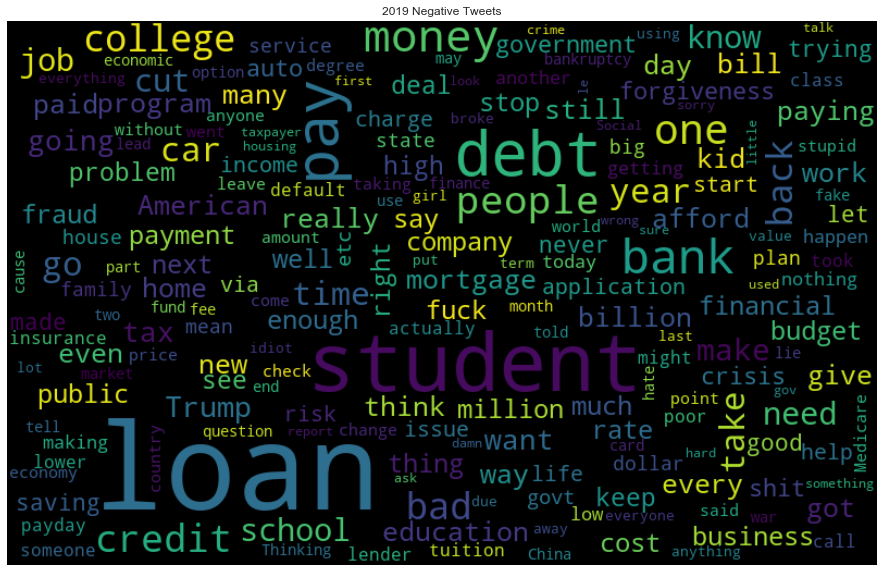

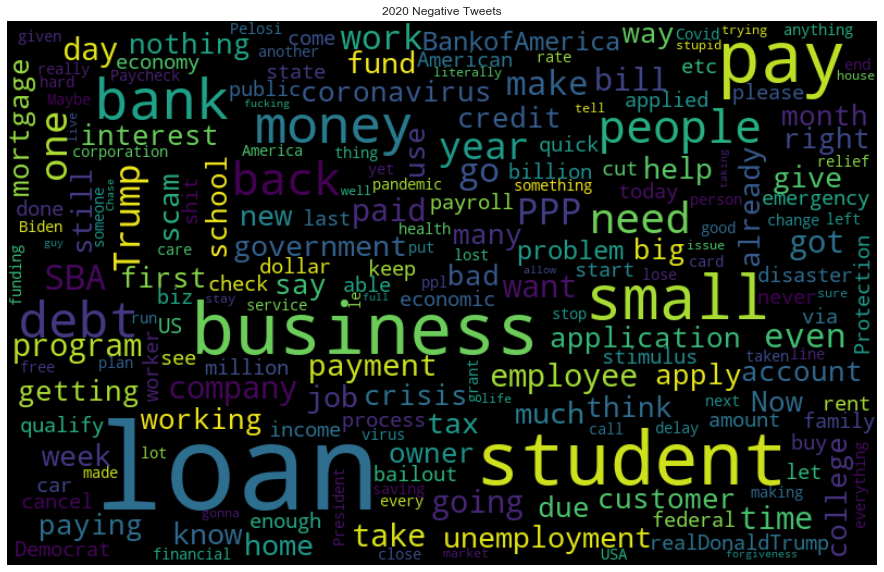

In [100]:
# Import module 
from wordcloud import WordCloud


# 2019 
all_words = ' '.join([text for text in tweets2019_df[tweets2019_df['Sentiment'] == 'Negative']['CleanTweets']])
wordcloud = WordCloud(collocations=False, width=800, height=500, random_state=5, max_font_size=110).generate(all_words)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("2019 Negative Tweets")
plt.show()

# 2020
all_words = ' '.join([text for text in tweets2020_df[tweets2020_df['Sentiment'] == 'Negative']['CleanTweets']])
wordcloud = WordCloud(collocations=False, width=800, height=500, random_state=5, max_font_size=110).generate(all_words)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("2020 Negative Tweets")
plt.show()

Although we will not go into extensive description of this, we also showcased wordclouds for the most common positive words for both 2019 & 2020, and these are depicted below. 

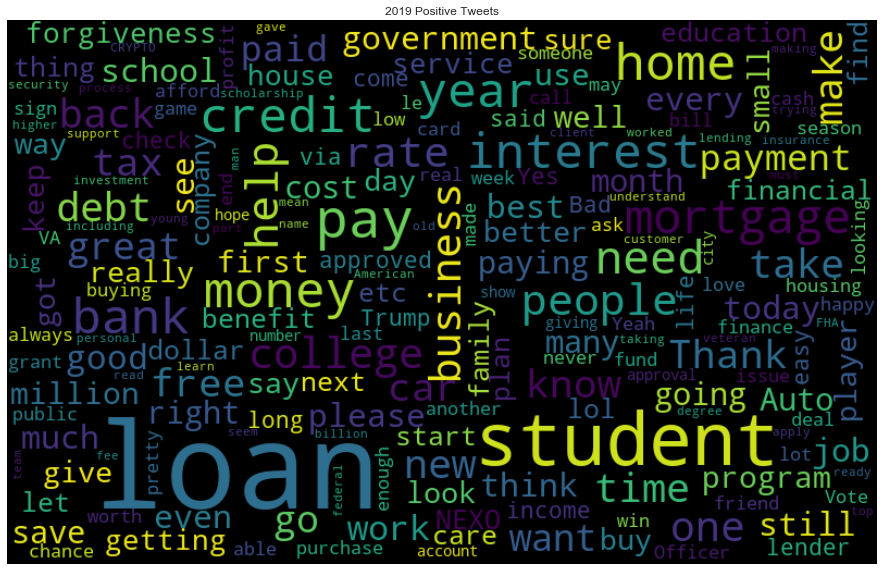

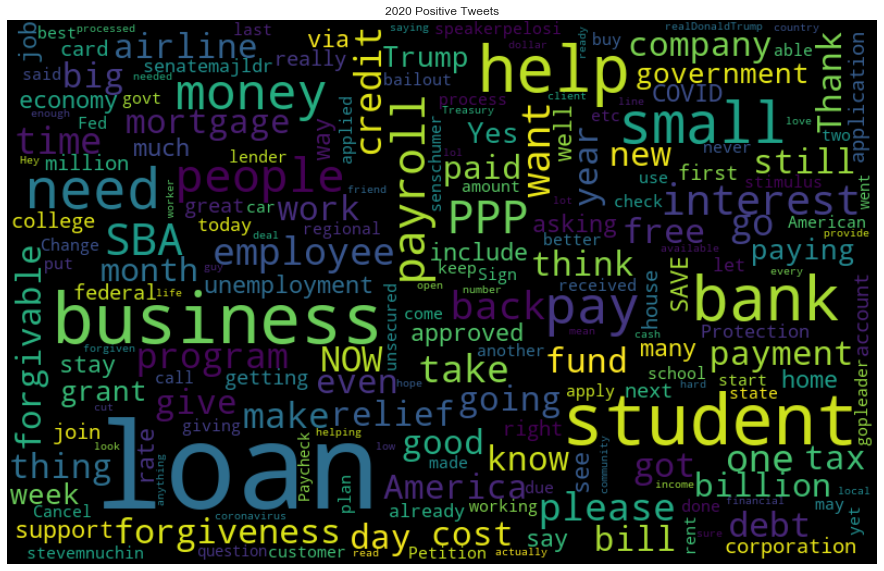

In [101]:
# Import module 
from wordcloud import WordCloud

#2019
all_words = ' '.join([text for text in tweets2019_df[tweets2019_df['Sentiment'] == 'Positive']['CleanTweets']])
wordcloud = WordCloud(collocations=False, width=800, height=500, random_state=5, max_font_size=110).generate(all_words)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("2019 Positive Tweets")
plt.show()


#2020
all_words = ' '.join([text for text in tweets2020_df[tweets2020_df['Sentiment'] == 'Positive']['CleanTweets']])
wordcloud = WordCloud(collocations=False, width=800, height=500, random_state=5, max_font_size=110).generate(all_words)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("2020 Positive Tweets")
plt.show()

### Corona Virus Sentiment Similarity

Lastly, we wanted to look at the sentiment of loan tweets relating to the coronavirus in 2020 to see how the coronavirus specifically is affecting lending. In order to understand coronavirus associated tweets about loans, our team conducted topic tagging and sentence similarity through USE. First, we performed topic tagging and pulled out tweets from 2020 dataset that explicitly contain words associated with the coronavirus. 

In [102]:
import numpy as np
import re

tweets2020_df['Corona'] = np.where(tweets2020_df.stripped.str.contains('(:^|\W)(covid|covid19|covid-19|corona|corona virus|coronavirus|COVID-19)', flags = re.IGNORECASE), 1, 0)

print(f"Corona {tweets2020_df['Corona'].sum()}")

Corona 144


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


This pulled about 144 tweets, which we then analyzed a small subset of to pull out one tweet example to perform sentence similarity.

In [103]:
print(tweets2020_df[tweets2020_df["Corona"] == 1].text.tail(25))

2693    Senate GOP coronavirus bill aides U.S. transit, airports but loans not cash for airlines https://reut.rs/2WA00vy  #news #business #socialpic.twitter.com/jRXxQLzxBG                                                                                                                                                                                             
2701    US @federalreserve laying groundwork for a potential loan holiday. A bank/market/business holiday is necessary: Federal Reserve Board - Agencies provide additional information to encourage financial institutions to work with borrowers affected by COVID-19 https://www.federalreserve.gov/newsevents/pressreleases/bcreg20200322a.htm …                    
2713    @narendramodi @FinMinIndia @ArvindKejriwal\nDear\nLoans, Bank Emi, house Rent Stop this All till Corona virus, because people are not going to work so how they can pay this All. Government should have supply the Foodstuff, medicine, public related things Etc. \n Humble 

Next, we imported the Universal Sentence Encoder and used our specifically selected tweeet as a query to perform sentence similarity solely on 2020 tweets. The reason we are only analyzing the 2020 tweets is because the coronavirus was not present in the economy this time last year, so any tweets that contain 'corona' are not referring to the coronavirus. 

In [104]:
import tensorflow as tf
import tensorflow_hub as hub

In [105]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
embed = hub.load(module_url) #download and load the model
print("Done!")

Done!


In [106]:
embeddings = embed(tweets2020_df.text)

In [107]:
import scipy.spatial

queries = ['Exactly, employment insurance. The point of the campaign is to cover students/grads who will go without employment because of covid. We’re not advocating for additional student loans.']
query_embeddings = embed(queries)

corona_idx=[]

for query, query_embedding in zip(queries, query_embeddings):
    distances = scipy.spatial.distance.cdist([query_embedding], embeddings, "cosine")[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])
    
    for idx, distance in results[0:]:
        if (1-distance) > 0.4: 
            corona_idx.append(idx)

In [108]:
corona_df = pd.DataFrame([tweets2020_df.loc[i] for i in corona_idx]).reset_index(drop=True)

After scraping these tweets, we developed a threshold for how similar a tweet must be to the example query to be included in the new coronavirus dataset. In this case, we set a threshold of 0.4 and above to capture a larger number of tweets, but still maintain a reasonable level of similarity. 

### Sentiment of Corona Related Tweets

Now, we perform the same sentiment preprocessing on this new coronavirus dataset with creating the 'C_Score' variable and the categorial 'Sentiment' Variable. Although this data set only includes about 100 tweets out of the scraped 3000, we still want to perform a sentiment analysis. We just need to know that this may not be completely indicative of the overall perception of loans and the coronavirus. We do believe that there are more tweets relating to the coronavirus that do not explicitly use any of the coronavirus words. For example, many of tweets talk about "stimulus programs" and "Trump" which are associated with strategies to minimize the impacts of the coronavirus. We did not want to include these keywords because it would be difficult to differentiate tweets that are discussing programs relating to the coronavirus and programs unrelated.

In [109]:
# Import the sentiment module (if you haven't already done so)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Import numpy (if you have not already done so)
import numpy as np

# Instantiate the sentiment analyzer (if you haven't already done so)
analyser = SentimentIntensityAnalyzer()

# Now get the compound sentiment score for each tweet
corona_df['C_Score'] = np.nan
for index, row in corona_df.iterrows(): 
    corona_df.loc[index, 'C_Score'] = analyser.polarity_scores(row['stripped'])['compound']
# Let's take a look!
pd.set_option('display.max_colwidth', -1)
corona_df[['stripped','C_Score']].head(-50)

,stripped,C_Score
0,"Exactly, employment insurance. The point of the campaign is to cover students/grads who will go without employment because of covid. We’re not advocating for additional student loans.",0.0000
1,So we should just write off a TRILLION DOLLARS in student loans with no debate? AYFKM? What about people who don’t have fancy degrees because they couldn’t afford college? Those are the people Democrat’s supposedly care about.,0.3695
2,So the relief package got blocked because the Democrats want to get rid of all of the student loans? Wtf does student loans have to do with people losing their jobs and struggling to pay bills???,-0.8394
3,This is essentially unemployment insurance for us independent contractors. I’m not completely out of work yet so I won’t qualify. I was talking about getting the SBA loan to stay afloat during this period of possible very little work.,-0.4404
4,his supporters are ALWAYS in a frenzy- it has nothing to do with anything dems do\n\ndems should state that they are NOT bailing out industries that rely on wage-slaves for profit- it's why C19 spread\nloans & grants only to those that pay living wage & paid time off to ALL WORKERS,0.6124
...,...,...
108,"Most COVID relief is 0-interest loans to ppl who need it like mom & pop retail, locally-owned restaurants, & payroll protection for min wage jobs & food insecur—HAHA JK it’s actually gifts to big banks, multinational hotel chains & tax loopholes for hedge funds. LetThemEatCake!",0.8318
109,"just got laid off until further notice, i don’t qualify for unemployment, and i have student loan bills, a car payment, rent, and i need to eat??? since i’m not at my new job at least 4 months i get no assistance this system is fucked up.",-0.8762
110,"The first mistake was underwriting the loans. But an even bigger mistake will be forgiving them. Claw it back from the university system, not the U.S. taxpayer. No more bailouts...for banks, insurance companies...or for college students. Best time in 50 years to get a job.",0.6187
111,Most of the money for corporations was in the form of LOANS- to make PAYROLL. Not bail outs like Obama.,-0.2755


In [110]:
print(f"Count positive tweets: {sum(corona_df['C_Score'] > 0.05)}")
print(f"Count netural tweets: {corona_df['C_Score'].between(-0.05, 0.05).sum()}")
print(f"Count negative tweets: {sum(corona_df['C_Score'] < -0.05)}")
print(f"Total number of tweets: {corona_df['C_Score'].count()}")
      
display(corona_df.C_Score.describe())

Count positive tweets: 69
Count netural tweets: 14
Count negative tweets: 80
Total number of tweets: 163


count    163.000000
mean    -0.023427  
std      0.510312  
min     -0.876200  
25%     -0.458800  
50%     -0.025800  
75%      0.397900  
max      0.950400  
Name: C_Score, dtype: float64

In the chart below, the sentiment is slightly skewed toward negative sentiment, which is unsurprising, given the 2020 negative word cloud. 

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Sentiment Distribution')]

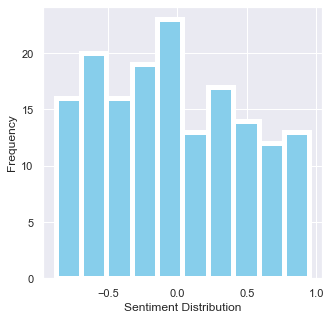

In [111]:
# import necessary modules (if not already imported)
import matplotlib.pyplot as plt
import seaborn as sns

# settings for seaborn plotting style
sns.set(color_codes=True)

# settings for seaborn plot sizes
sns.set(rc={'figure.figsize':(5,5)})

# Create Histogram
ax = sns.distplot(corona_df['C_Score'],
                  bins=10,
                  kde=False,
                  color='skyblue',
                  hist_kws={"linewidth": 5,'alpha':1})
ax.set(xlabel='Sentiment Distribution', ylabel='Frequency')

In [112]:
# create new column
corona_df['Sentiment'] = np.nan

# Loop through rows of dataframe and determine strings for new column "Sentiment"
for index, row in corona_df.iterrows(): 
    if corona_df.loc[index, 'C_Score'] > 0.05 : 
            corona_df.loc[index, 'Sentiment'] = "Positive"       
    elif corona_df.loc[index, 'C_Score'] < -0.05 :
            corona_df.loc[index, 'Sentiment'] = "Negative"   
    else : 
        corona_df.loc[index, 'Sentiment'] = "Neutral"

The pie chart below validates the skew toward negativity with 49% of the tweets being classified as negative and 42% of the tweets classified as positive. 

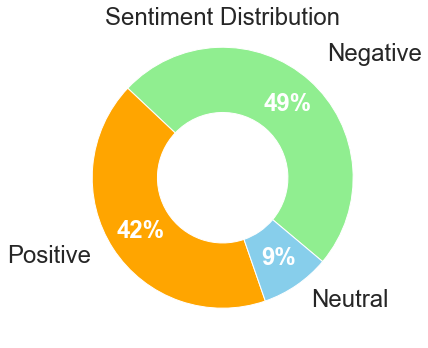

In [113]:
# import necessary modules (if not already imported)
import matplotlib.pyplot as plt

# Set font size
plt.rcParams['font.size']=24

# Define figure
fig, ax = plt.subplots(figsize=(9, 6), subplot_kw=dict(aspect="equal"))

# Get count by sentiment category from tweets_df
sentiment_counts = corona_df.Sentiment.value_counts()
labels = sentiment_counts.index

# Define colors
color_palette_list = ['lightgreen', 'orange', 'skyblue']

# Generate graph components
wedges, texts, autotexts = ax.pie(sentiment_counts, wedgeprops=dict(width=0.5), startangle=-40,  
       colors=color_palette_list[0:3], autopct='%1.0f%%', pctdistance=.75, textprops={'color':"w", 'weight':'bold'})

# Plot wedges
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    ax.annotate(labels[i], xy=(x, y), xytext=(1.2*x, 1.2*y),
                horizontalalignment=horizontalalignment)
# Set title
ax.set_title("Sentiment Distribution", y=.95, fontsize = 24)

# Show Donut Chart
plt.show()

Additionally, we showed a time series of sentiment for tweets over the 2020 time period. There seems to be fairly large variation between dates, however we do not think that this is necesssarily important or impactful given the small subset of tweets that we are using for coronavirus sentiment analysis. 

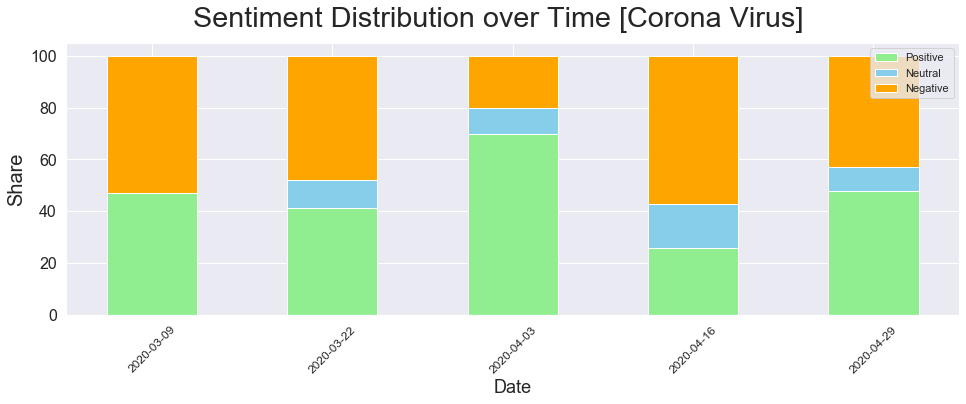

In [114]:
import math
corona_df['date'] = [one.date() for one in corona_df['timestamp']]
corona_df = corona_df.sort_values(by=['date'])

sentiments = ["Positive", "Neutral", "Negative"]
positiveProps = (corona_df[corona_df.Sentiment == 'Positive'].groupby(['date']).count()[['Sentiment']]/ corona_df.groupby(['date']).count()[['Sentiment']])*100
neutralProps = (corona_df[corona_df.Sentiment == 'Neutral'].groupby(['date']).count()[['Sentiment']]/ corona_df.groupby(['date']).count()[['Sentiment']])*100
negativeProps = (corona_df[corona_df.Sentiment == 'Negative'].groupby(['date']).count()[['Sentiment']]/ corona_df.groupby(['date']).count()[['Sentiment']])*100
 
positiveProps = positiveProps['Sentiment'].tolist()
neutralProps = neutralProps['Sentiment'].tolist()
negativeProps = negativeProps['Sentiment'].tolist()
plt.figure(figsize=[16, 5])
barWidth = 0.5
labels = corona_df.date.unique()
r = np.arange(len(labels))
positiveProps = [0 if math.isnan(x) else x for x in positiveProps]
neutralProps = [0 if math.isnan(x) else x for x in neutralProps]
negativeProps = [0 if math.isnan(x) else x for x in negativeProps]

plt.bar(r,positiveProps, color='lightgreen', edgecolor='white', width=barWidth)
plt.bar(r, neutralProps, bottom=positiveProps, color='skyblue', edgecolor='white', width=barWidth)
plt.bar(r, negativeProps, bottom=[i+j for i,j in zip(positiveProps, neutralProps)], color='orange', edgecolor='white', width=barWidth)
 
plt.xticks(r, labels, rotation = 45, fontsize=12)
plt.yticks(fontsize=16)
plt.suptitle('Sentiment Distribution over Time [Coronaviirus]')
plt.xlabel("Date", fontsize=18)
plt.ylabel("Share", fontsize=20)
plt.legend(sentiments)
plt.show()

### Word Cloud for Coronavirus Loan Tweets

Again, we perform tweet prprocessing to clean and tokenize the tweets for a wordcloud. This word cloud will help our team determine the most common themes with loans and the coronavirus. 

In [115]:
# 1. Start by importing the necessary modules
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

# 3. Set-up two new columns: one for tokens and one for cleaned tweets
corona_df["Tokens"] = [[] for _ in range(len(corona_df))]
corona_df["CleanTweets"] = [[] for _ in range(len(corona_df))]
#tweets_df['Tokens'] = tweets_df['Tokens'].astype('object')

# 3. Now tokenize each tweet and store its tokens in a new column
for index, row in corona_df.iterrows(): 
    corona_df.at[index, 'Tokens'] = tknzr.tokenize(row['stripped']) 

In [116]:
# 1. Start by importing required modules
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from nltk.stem import WordNetLemmatizer

# 2. Instantiate Stemmer
ps = PorterStemmer()
le = WordNetLemmatizer()

# 3. Now clean tweets (stripped tweets!) one by one
for index, row in corona_df.iterrows(): 
    # Remove Punctuation
    words = [w for w in row['Tokens']
        if w.isalpha()]  #returns "true" if string only includes alphabetical strings
    
    # Remove Stopwords
    words = [w for w in words
       if w not in stopwords.words('english')]

    # Stem or Lemmatize tokens
    #words = [ps.stem(w) for w in words]
    words = [le.lemmatize(w) for w in words]
      
    # Write cleaned list of tokens into cell
    corona_df.at[index, 'Tokens'] = words

    # Put stems back into a sentence
    sentence = " ".join(token for token in words)

     # Write cleaned sentences into cell
    corona_df.at[index, 'CleanTweets'] = sentence
        
# 4. Finally, check if it worked
corona_df.Tokens.head(10)

137    [SenSanders, I, couple, question, forgiving, student, loan, How, institution, gave, loan, going, repaid, If, repaid, employee, work, company, going, get, paid]                                                  
32     [And, I, like, know, congress, offer, small, business, relief, program, deal, people, able, pay, loan, This, government, role]                                                                                   
68     [I, agree, student, loan, debt, GND, So, alienate, potential, support, base, I, find, hard, argument, believe, Sanders, would, differently, table, turned]                                                       
146    [That, even, pay, year, student, loan, Not, even, month, Cheap, Tory, bastard]                                                                                                                                   
88     [time, like, plan, student, loan, Instead, throwing, every, cent, debt, held, saving, case, needed, cash, We, happened, need,

For the below word cloud, we are just looking at the most common negative words in the tweets. Our team pulled out "government", "unemployment", "pay", "forgiveness", "security", "insurance", etc. With these words, it seems that people are primarily concerned ability to pay back loans and the leniency that loan providers will have on late payments. Additionally, there is a concern about security. This could mean financial security with borrowing money, and concern with security of invested money. This means that the loan industry is being impacted from two different directions, the lenders and the borrowers. 

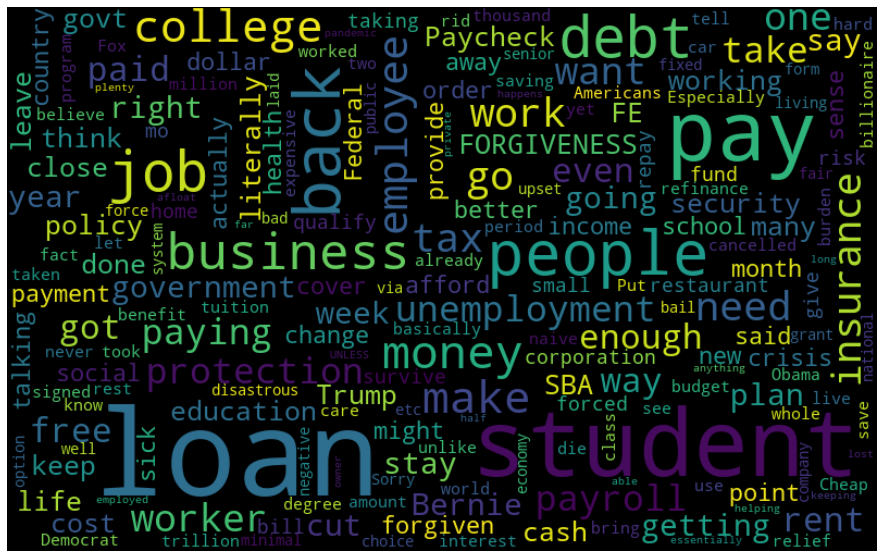

In [119]:
## Import module 
from wordcloud import WordCloud

all_words = ' '.join([text for text in corona_df[corona_df['Sentiment'] == 'Negative']['CleanTweets']])
wordcloud = WordCloud(collocations=False, width=800, height=500, random_state=5, max_font_size=110).generate(all_words)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

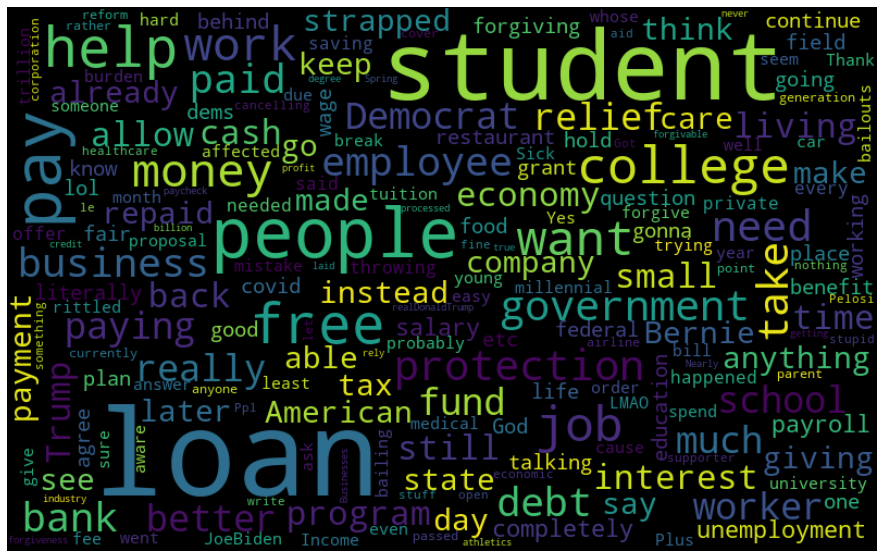

In [118]:
## Import module 
from wordcloud import WordCloud

all_words = ' '.join([text for text in corona_df[corona_df['Sentiment'] == 'Positive']['CleanTweets']])
wordcloud = WordCloud(collocations=False, width=800, height=500, random_state=5, max_font_size=110).generate(all_words)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

So, our team took to competitive research to understand how different peer2peer lending platforms are adjusting strategies to comfort their lenders and borrowers during this crisis. The 4 platforms we researched were: Lending Club, SoFi, Prosper, and Upstart. As a general overview, Lending Club has the largest amount of resources and presence on the internet for their strategies to stay afloat and help consumers during this time. Specifically, Lending Club has been active in government to encourage financial assistance programs, including passing the CARES act. Within their own company, Lending Club is providing a longer grace period for late payments with alternative payment plans. In order to mitigate risk, Lending Club is also suspending specific loan offerings, including any loans with a grade D or below and increasing the interest rate that borrowers are charged. All of the competitors have similar grace periods and waiving of fees to help people who are struggling. One strategy to call out is Prospers offering of a Home Equity Line of Credit that gives customers the flexibility to access a line of credit by utilizing their home equity. This is offered to any user, with the rate and credit limit varying based on profile. 

During this crisis, peer2peer lending is taking a hit with skittish lenders backing out of loans and borrowers unable to fully pay. In order for Lending Club to stay afloat, our team recommends that they continue transparency with consumers with strategies taken to assist both borrowers and lenders. Additionally, these strategies should focus on minimizing risk of lending and borrowing. People are scared of losing money, especially with layoffs, furloughs, and closing of businesses, Any strategy that can lower the risk of investing the platform will be beneficial to Lending Club. Many of Lending Club’s competitors seem to be focused on assisting borrowers with paying off loans, but Lending Club is taking a better strategy to attack from both sides with assisting borrowers and lenders. Without the lenders, Lending Club would have no funds to stay open. 

## Conclusion & Results

## Citations

Source of code with the correlation calculation: https://www.kaggle.com/pavlofesenko/minimizing-risks-for-loan-investments

Source for information about LendingClub and recommended strategies: https://www.liebertpub.com/doi/full/10.1089/big.2018.0092

Source for information about LIBOR: https://www.firstrepublic.com/finmkts/historical-interest-rates

Source for dealing with missing values: https://www.kaggle.com/piyras23/interest-rate-dealing-with-missing-values